# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

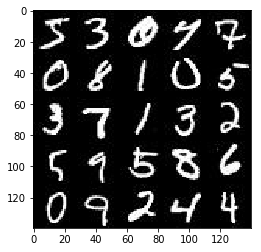

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

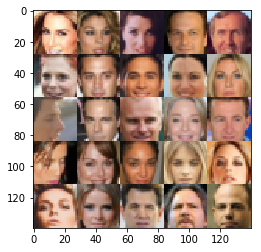

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_input')
    z_input = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    lr = tf.placeholder(tf.float32, name='lr')

    return real_input, z_input, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        conv1 = tf.layers.conv2d(images, 64, 5, 2, padding='same')
        conv1 = tf.maximum(alpha * conv1, conv1)
        #print(conv1.get_shape().as_list())
        
        conv2 = tf.layers.conv2d(conv1, 128, 5, 2, padding='same')
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = tf.maximum(alpha * conv2, conv2)
        #print(conv2.get_shape().as_list())
        
        conv3 = tf.layers.conv2d(conv2, 256, 5, 2, padding='same')
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        conv3 = tf.maximum(alpha * conv3, conv3)
        #print(conv3.get_shape().as_list())
        
        conv4 = tf.layers.conv2d(conv3, 512, 5, 1, padding='same')
        conv4 = tf.layers.batch_normalization(conv4, training=True)
        conv4 = tf.maximum(alpha * conv4, conv4)
        #print(conv4.get_shape().as_list())
        
        dimensions = conv4.get_shape().as_list()
        flatten = tf.reshape(conv4, (-1, dimensions[1]*dimensions[2]*dimensions[3]))
        logits = tf.layers.dense(flatten, 1)
        out = tf.nn.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        dense = tf.layers.dense(z, 2*2*1024)
        dense = tf.reshape(dense, (-1, 2, 2, 1024))
        dense_norm = tf.layers.batch_normalization(dense, training=is_train)
        dense_relu = tf.maximum(alpha * dense_norm, dense_norm)
        #dense_relu = tf.nn.relu(dense_norm)
        
        #print(dense_relu.get_shape().as_list())
        conv1 = tf.layers.conv2d_transpose(dense_relu, 512, 5, 2, padding='SAME')
        #print(conv1.get_shape().as_list())
        conv1_norm = tf.layers.batch_normalization(conv1, training=is_train)
        conv1_relu = tf.maximum(alpha * conv1_norm, conv1_norm)
        #conv1_relu = tf.nn.relu(conv1_norm)
        
        #print(conv1_relu.get_shape().as_list())
        conv2 = tf.layers.conv2d_transpose(conv1_relu, 256, 4, 1, padding='VALID')
        #print(conv2.get_shape().as_list())
        conv2_norm = tf.layers.batch_normalization(conv2, training=is_train)
        conv2_relu = tf.maximum(alpha * conv2_norm, conv2_norm)
        #conv1_relu = tf.nn.relu(conv1_norm)
        
        #print(conv2_relu.get_shape().as_list())
        conv3 = tf.layers.conv2d_transpose(conv2_relu, 128, 5, 2, padding='SAME')
        #print(conv3.get_shape().as_list())
        conv3_norm = tf.layers.batch_normalization(conv3, training=is_train)
        conv3_relu = tf.maximum(alpha * conv3_norm, conv3_norm)
        #conv2_relu = tf.nn.relu(conv2_norm)
        
        
        #print(conv3_relu.get_shape().as_list())
        conv4 = tf.layers.conv2d_transpose(conv3_relu, out_channel_dim, 5, 2, padding='SAME')
        #print(conv4.get_shape().as_list())
        output = tf.nn.tanh(conv4)
        
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    #Perform label smoothing as advised here: https://github.com/soumith/ganhacks#6-use-soft-and-noisy-labels
    real_label_dim = d_model_real.get_shape().as_list()[1]
    real_labels_smoothed = tf.random_uniform([real_label_dim], 0.7, 1.2)
    real_labels_smoothed = tf.reshape(real_labels_smoothed, (-1, real_label_dim))
    
    fake_label_dim = d_model_fake.get_shape().as_list()[1]
    fake_labels_smoothed = tf.random_uniform([fake_label_dim], 0, 0.3)
    fake_labels_smoothed = tf.reshape(fake_labels_smoothed, (-1, fake_label_dim))
    fake_labels_smoothed_ones = tf.random_uniform([fake_label_dim], 0.7, 1.2)
    fake_labels_smoothed_ones = tf.reshape(fake_labels_smoothed_ones, (-1, fake_label_dim))
    
    d_loss_real = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                        labels=real_labels_smoothed))
                                                        #labels=tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                        labels=fake_labels_smoothed))
                                                        #labels=tf.zeros_like(d_model_real)))
    g_loss = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                        labels=fake_labels_smoothed_ones))
                                                        #labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [19]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    real_input, z_input, lr = model_inputs(*data_shape[1:], z_dim)
    d_loss, g_loss = model_loss(real_input, z_input, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                num_gen = 1
                batch_z = np.random.uniform(-1, 1, size=(num_gen, batch_size, z_dim))
                
                #normalize images from (-0.5, 0.5) to (-1, 1)
                batch_images = batch_images * 2
                
                sess.run(d_train_opt, feed_dict={real_input: batch_images, z_input: batch_z[0]})
                for i in range(num_gen):
                    sess.run(g_train_opt, feed_dict={z_input: batch_z[i], real_input: batch_images})
                
                if steps % 20 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({z_input: batch_z[0], real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: batch_z[0]})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps%150 == 0:
                    show_generator_output(sess, 25, z_input, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.0986... Generator Loss: 0.7543
Epoch 1/2... Discriminator Loss: -0.9915... Generator Loss: 3.9011
Epoch 1/2... Discriminator Loss: 0.4193... Generator Loss: 0.6430
Epoch 1/2... Discriminator Loss: 0.7725... Generator Loss: 4.9382
Epoch 1/2... Discriminator Loss: 1.1658... Generator Loss: 0.6186
Epoch 1/2... Discriminator Loss: 1.0978... Generator Loss: 2.8039
Epoch 1/2... Discriminator Loss: 0.9933... Generator Loss: 0.8744


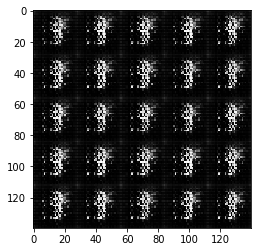

Epoch 1/2... Discriminator Loss: 0.9055... Generator Loss: 2.5666
Epoch 1/2... Discriminator Loss: -0.0265... Generator Loss: 1.6038
Epoch 1/2... Discriminator Loss: 0.1587... Generator Loss: 0.6152
Epoch 1/2... Discriminator Loss: -0.6537... Generator Loss: 4.4856
Epoch 1/2... Discriminator Loss: 0.4547... Generator Loss: 0.7988
Epoch 1/2... Discriminator Loss: 1.0751... Generator Loss: 1.3277
Epoch 1/2... Discriminator Loss: 1.1209... Generator Loss: 2.6050
Epoch 1/2... Discriminator Loss: 1.8755... Generator Loss: 4.0566


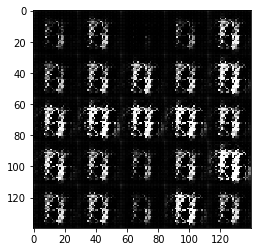

Epoch 1/2... Discriminator Loss: 0.4291... Generator Loss: 0.8652
Epoch 1/2... Discriminator Loss: 1.1690... Generator Loss: 1.9579
Epoch 1/2... Discriminator Loss: 0.6659... Generator Loss: 2.6538
Epoch 1/2... Discriminator Loss: 0.0223... Generator Loss: 3.6362
Epoch 1/2... Discriminator Loss: 0.9304... Generator Loss: 0.7487
Epoch 1/2... Discriminator Loss: 0.5263... Generator Loss: 1.2826
Epoch 1/2... Discriminator Loss: -0.1104... Generator Loss: 2.5095


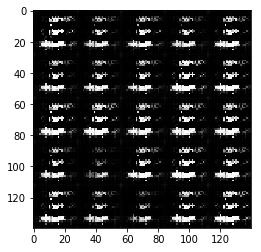

Epoch 1/2... Discriminator Loss: -0.1139... Generator Loss: 2.9081
Epoch 1/2... Discriminator Loss: 0.7015... Generator Loss: 0.5108
Epoch 1/2... Discriminator Loss: 1.0141... Generator Loss: 0.9959
Epoch 1/2... Discriminator Loss: 0.9363... Generator Loss: 3.2784
Epoch 1/2... Discriminator Loss: 1.8401... Generator Loss: 0.2276
Epoch 1/2... Discriminator Loss: 0.8775... Generator Loss: 1.7480
Epoch 1/2... Discriminator Loss: 0.1891... Generator Loss: 0.9600
Epoch 1/2... Discriminator Loss: 0.0722... Generator Loss: 2.2968


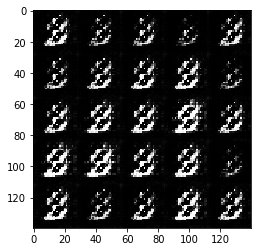

Epoch 1/2... Discriminator Loss: -0.4530... Generator Loss: 0.5434
Epoch 1/2... Discriminator Loss: 1.8681... Generator Loss: 1.9402
Epoch 1/2... Discriminator Loss: 1.0687... Generator Loss: 2.4662
Epoch 1/2... Discriminator Loss: 0.7746... Generator Loss: 1.2126
Epoch 1/2... Discriminator Loss: 1.2392... Generator Loss: 2.7296
Epoch 1/2... Discriminator Loss: 1.3108... Generator Loss: 0.5632
Epoch 1/2... Discriminator Loss: 0.4828... Generator Loss: 3.1254


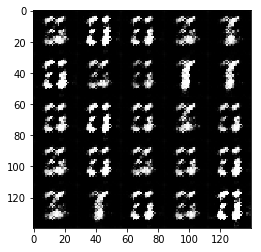

Epoch 1/2... Discriminator Loss: 0.3843... Generator Loss: 0.4658
Epoch 1/2... Discriminator Loss: 0.4589... Generator Loss: 2.5214
Epoch 1/2... Discriminator Loss: 1.6453... Generator Loss: 0.2330
Epoch 1/2... Discriminator Loss: 0.6039... Generator Loss: 1.7313
Epoch 1/2... Discriminator Loss: 0.1376... Generator Loss: 2.3446
Epoch 1/2... Discriminator Loss: 1.5691... Generator Loss: 0.7075
Epoch 1/2... Discriminator Loss: 0.9006... Generator Loss: 1.1258
Epoch 1/2... Discriminator Loss: 0.7555... Generator Loss: 1.3889


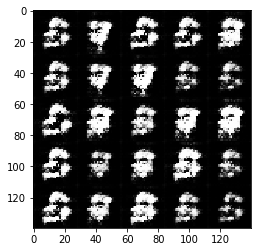

Epoch 1/2... Discriminator Loss: 0.5083... Generator Loss: 1.2018
Epoch 1/2... Discriminator Loss: 0.5700... Generator Loss: 2.0312
Epoch 1/2... Discriminator Loss: 1.0064... Generator Loss: 1.6173
Epoch 1/2... Discriminator Loss: 0.5724... Generator Loss: 1.6803
Epoch 1/2... Discriminator Loss: 0.8150... Generator Loss: 2.1101
Epoch 1/2... Discriminator Loss: 0.9815... Generator Loss: 1.6334
Epoch 1/2... Discriminator Loss: 0.7817... Generator Loss: 2.0266


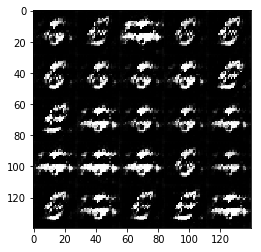

Epoch 1/2... Discriminator Loss: 1.2817... Generator Loss: 0.9383
Epoch 1/2... Discriminator Loss: 0.8423... Generator Loss: 2.6633
Epoch 1/2... Discriminator Loss: 0.1272... Generator Loss: 0.8529
Epoch 1/2... Discriminator Loss: 0.7933... Generator Loss: 0.8626
Epoch 1/2... Discriminator Loss: 0.4608... Generator Loss: 1.6472
Epoch 1/2... Discriminator Loss: 0.0966... Generator Loss: 1.1134
Epoch 1/2... Discriminator Loss: 0.0057... Generator Loss: 1.4191
Epoch 1/2... Discriminator Loss: 2.0431... Generator Loss: 0.5434


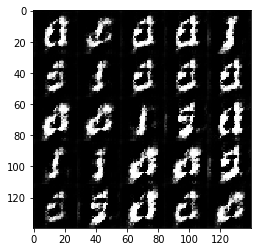

Epoch 1/2... Discriminator Loss: 1.1723... Generator Loss: 0.9433
Epoch 1/2... Discriminator Loss: 0.6454... Generator Loss: 1.7955
Epoch 1/2... Discriminator Loss: 0.4418... Generator Loss: 1.7022
Epoch 1/2... Discriminator Loss: 0.2046... Generator Loss: 0.7697
Epoch 1/2... Discriminator Loss: 0.9036... Generator Loss: 0.5127
Epoch 1/2... Discriminator Loss: 1.1025... Generator Loss: 3.2378
Epoch 1/2... Discriminator Loss: 0.3435... Generator Loss: 0.6712


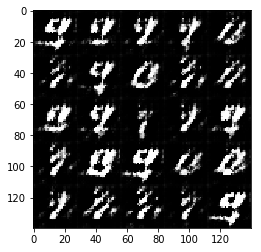

Epoch 1/2... Discriminator Loss: 0.2335... Generator Loss: 0.7473
Epoch 1/2... Discriminator Loss: 0.4258... Generator Loss: 1.2011
Epoch 1/2... Discriminator Loss: 1.1652... Generator Loss: 0.8045
Epoch 1/2... Discriminator Loss: 0.9807... Generator Loss: 2.3442
Epoch 1/2... Discriminator Loss: 1.0579... Generator Loss: 1.5335
Epoch 1/2... Discriminator Loss: 0.7000... Generator Loss: 0.7206
Epoch 1/2... Discriminator Loss: 1.1922... Generator Loss: 1.4523
Epoch 1/2... Discriminator Loss: 1.1630... Generator Loss: 1.6186


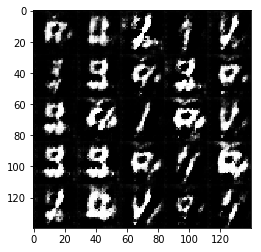

Epoch 1/2... Discriminator Loss: 0.8333... Generator Loss: 1.2450
Epoch 1/2... Discriminator Loss: 1.1807... Generator Loss: 0.5578
Epoch 1/2... Discriminator Loss: 1.0434... Generator Loss: 1.1639
Epoch 1/2... Discriminator Loss: 1.2790... Generator Loss: 1.0157
Epoch 1/2... Discriminator Loss: 1.6618... Generator Loss: 0.6244
Epoch 1/2... Discriminator Loss: 0.9929... Generator Loss: 2.4651
Epoch 1/2... Discriminator Loss: 0.5095... Generator Loss: 1.8386


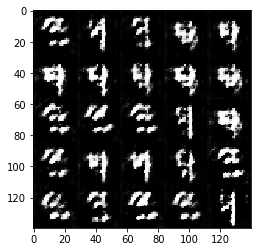

Epoch 1/2... Discriminator Loss: 0.9138... Generator Loss: 1.0922
Epoch 1/2... Discriminator Loss: 1.2728... Generator Loss: 2.3159
Epoch 1/2... Discriminator Loss: 0.7600... Generator Loss: 0.9688
Epoch 1/2... Discriminator Loss: 0.5393... Generator Loss: 1.6295
Epoch 1/2... Discriminator Loss: 1.1160... Generator Loss: 1.6306
Epoch 1/2... Discriminator Loss: 0.4054... Generator Loss: 2.6982
Epoch 1/2... Discriminator Loss: 1.7243... Generator Loss: 0.6070
Epoch 1/2... Discriminator Loss: 1.9584... Generator Loss: 0.3422


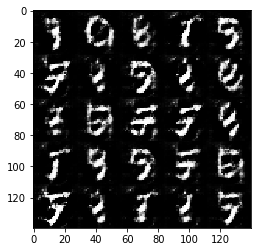

Epoch 1/2... Discriminator Loss: 0.8119... Generator Loss: 2.1213
Epoch 1/2... Discriminator Loss: 1.2208... Generator Loss: 2.6362
Epoch 1/2... Discriminator Loss: 0.4377... Generator Loss: 1.7378
Epoch 1/2... Discriminator Loss: 0.7570... Generator Loss: 1.0086
Epoch 1/2... Discriminator Loss: 0.8167... Generator Loss: 1.4209
Epoch 1/2... Discriminator Loss: 0.5262... Generator Loss: 0.6013
Epoch 1/2... Discriminator Loss: 2.4437... Generator Loss: 0.4595


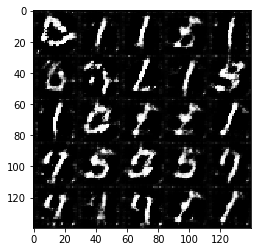

Epoch 1/2... Discriminator Loss: 1.5693... Generator Loss: 0.3689
Epoch 1/2... Discriminator Loss: 0.3772... Generator Loss: 1.5019
Epoch 1/2... Discriminator Loss: 1.1678... Generator Loss: 0.5394
Epoch 1/2... Discriminator Loss: 1.5556... Generator Loss: 0.8222
Epoch 1/2... Discriminator Loss: 0.8329... Generator Loss: 0.6965
Epoch 1/2... Discriminator Loss: 0.3113... Generator Loss: 1.2595
Epoch 1/2... Discriminator Loss: 1.2509... Generator Loss: 1.7003
Epoch 1/2... Discriminator Loss: 1.0050... Generator Loss: 1.1985


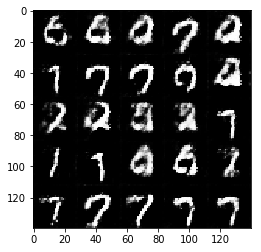

Epoch 1/2... Discriminator Loss: 0.5394... Generator Loss: 0.4469
Epoch 1/2... Discriminator Loss: 1.3075... Generator Loss: 0.4718
Epoch 1/2... Discriminator Loss: 1.0213... Generator Loss: 1.1200
Epoch 1/2... Discriminator Loss: 0.7020... Generator Loss: 1.8346
Epoch 1/2... Discriminator Loss: 1.0779... Generator Loss: 1.6271
Epoch 1/2... Discriminator Loss: 0.8491... Generator Loss: 1.0794
Epoch 1/2... Discriminator Loss: 0.9529... Generator Loss: 0.7856


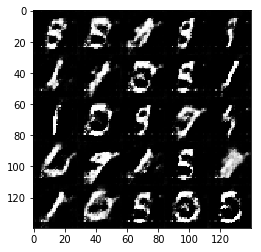

Epoch 1/2... Discriminator Loss: 0.4622... Generator Loss: 1.9891
Epoch 1/2... Discriminator Loss: 0.4895... Generator Loss: 1.4564
Epoch 1/2... Discriminator Loss: 0.9510... Generator Loss: 0.9143
Epoch 1/2... Discriminator Loss: 1.3750... Generator Loss: 0.7333
Epoch 1/2... Discriminator Loss: 0.5810... Generator Loss: 1.6486
Epoch 1/2... Discriminator Loss: 0.8611... Generator Loss: 1.8567
Epoch 1/2... Discriminator Loss: 0.5155... Generator Loss: 2.2871
Epoch 1/2... Discriminator Loss: 1.2888... Generator Loss: 1.0755


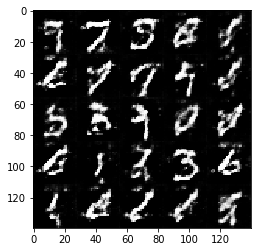

Epoch 1/2... Discriminator Loss: 1.3219... Generator Loss: 1.5872
Epoch 1/2... Discriminator Loss: 0.9102... Generator Loss: 1.3371
Epoch 1/2... Discriminator Loss: 0.6771... Generator Loss: 1.2266
Epoch 1/2... Discriminator Loss: 0.4890... Generator Loss: 0.8398
Epoch 1/2... Discriminator Loss: 1.0059... Generator Loss: 2.1379
Epoch 1/2... Discriminator Loss: 1.2053... Generator Loss: 0.7226
Epoch 1/2... Discriminator Loss: 0.4921... Generator Loss: 0.9414


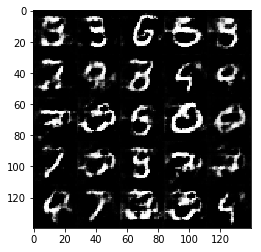

Epoch 1/2... Discriminator Loss: 0.3928... Generator Loss: 0.7399
Epoch 1/2... Discriminator Loss: 1.0906... Generator Loss: 1.4263
Epoch 1/2... Discriminator Loss: 0.6193... Generator Loss: 0.7129
Epoch 1/2... Discriminator Loss: 0.5641... Generator Loss: 1.5959
Epoch 1/2... Discriminator Loss: 0.7947... Generator Loss: 0.5637
Epoch 1/2... Discriminator Loss: 1.2936... Generator Loss: 0.8076
Epoch 1/2... Discriminator Loss: 1.2450... Generator Loss: 1.0535
Epoch 1/2... Discriminator Loss: 1.5315... Generator Loss: 0.6295


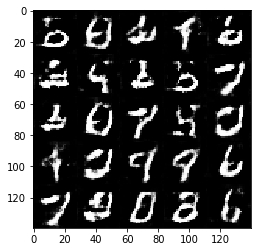

Epoch 1/2... Discriminator Loss: 1.2278... Generator Loss: 0.9330
Epoch 1/2... Discriminator Loss: 1.9312... Generator Loss: 0.3471
Epoch 1/2... Discriminator Loss: 0.7013... Generator Loss: 1.3686
Epoch 1/2... Discriminator Loss: 1.0579... Generator Loss: 1.2276
Epoch 1/2... Discriminator Loss: 1.1096... Generator Loss: 0.6930
Epoch 1/2... Discriminator Loss: 0.8279... Generator Loss: 0.3772
Epoch 1/2... Discriminator Loss: 1.4551... Generator Loss: 0.6539


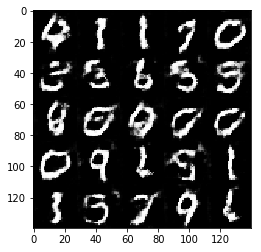

Epoch 1/2... Discriminator Loss: 1.0255... Generator Loss: 1.0456
Epoch 1/2... Discriminator Loss: 0.8720... Generator Loss: 1.0769
Epoch 1/2... Discriminator Loss: 0.9304... Generator Loss: 0.9990
Epoch 1/2... Discriminator Loss: 0.3442... Generator Loss: 0.7356
Epoch 1/2... Discriminator Loss: 0.9466... Generator Loss: 0.6483
Epoch 1/2... Discriminator Loss: 1.3162... Generator Loss: 0.8369
Epoch 1/2... Discriminator Loss: 0.9845... Generator Loss: 0.7413
Epoch 1/2... Discriminator Loss: 1.0204... Generator Loss: 0.8316


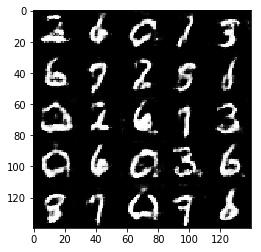

Epoch 1/2... Discriminator Loss: 1.3148... Generator Loss: 0.4321
Epoch 1/2... Discriminator Loss: 1.3659... Generator Loss: 0.9988
Epoch 1/2... Discriminator Loss: 1.3166... Generator Loss: 0.8710
Epoch 1/2... Discriminator Loss: 1.7622... Generator Loss: 0.4344
Epoch 1/2... Discriminator Loss: 1.2955... Generator Loss: 0.5818
Epoch 1/2... Discriminator Loss: 1.3780... Generator Loss: 1.4208
Epoch 1/2... Discriminator Loss: 1.0700... Generator Loss: 0.7765


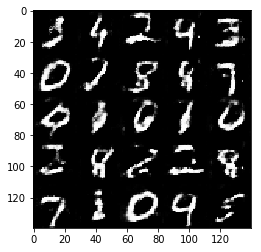

Epoch 1/2... Discriminator Loss: 1.1728... Generator Loss: 0.7064
Epoch 1/2... Discriminator Loss: 0.9623... Generator Loss: 0.7832
Epoch 1/2... Discriminator Loss: 1.4665... Generator Loss: 0.5068
Epoch 1/2... Discriminator Loss: 0.8215... Generator Loss: 1.7591
Epoch 1/2... Discriminator Loss: 1.3986... Generator Loss: 0.6688
Epoch 1/2... Discriminator Loss: 1.8700... Generator Loss: 0.4737
Epoch 1/2... Discriminator Loss: 1.2260... Generator Loss: 1.3145
Epoch 1/2... Discriminator Loss: 1.6686... Generator Loss: 0.3171


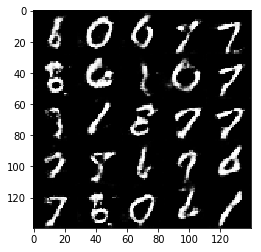

Epoch 1/2... Discriminator Loss: 1.8155... Generator Loss: 0.3211
Epoch 1/2... Discriminator Loss: 1.5869... Generator Loss: 0.6228
Epoch 1/2... Discriminator Loss: 1.2129... Generator Loss: 1.2734
Epoch 1/2... Discriminator Loss: 0.1668... Generator Loss: 0.5842
Epoch 1/2... Discriminator Loss: 1.1181... Generator Loss: 1.2840
Epoch 1/2... Discriminator Loss: 0.3830... Generator Loss: 1.0463
Epoch 1/2... Discriminator Loss: 1.2341... Generator Loss: 1.2199


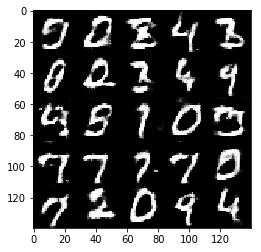

Epoch 1/2... Discriminator Loss: 0.6937... Generator Loss: 0.3375
Epoch 1/2... Discriminator Loss: 0.5665... Generator Loss: 0.9173
Epoch 1/2... Discriminator Loss: 0.8752... Generator Loss: 1.0382
Epoch 1/2... Discriminator Loss: 1.5179... Generator Loss: 0.5400
Epoch 1/2... Discriminator Loss: 0.4181... Generator Loss: 0.7177
Epoch 1/2... Discriminator Loss: 0.6097... Generator Loss: 0.5864
Epoch 1/2... Discriminator Loss: 0.6905... Generator Loss: 0.6898
Epoch 1/2... Discriminator Loss: 1.0786... Generator Loss: 0.8033


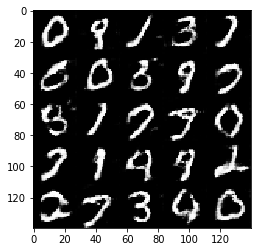

Epoch 1/2... Discriminator Loss: 1.1541... Generator Loss: 1.3788
Epoch 1/2... Discriminator Loss: 0.3783... Generator Loss: 0.8410
Epoch 1/2... Discriminator Loss: 2.2550... Generator Loss: 0.5510
Epoch 1/2... Discriminator Loss: 1.0715... Generator Loss: 0.7628
Epoch 1/2... Discriminator Loss: 1.5709... Generator Loss: 0.5471
Epoch 1/2... Discriminator Loss: 0.6518... Generator Loss: 0.9899
Epoch 1/2... Discriminator Loss: 0.3723... Generator Loss: 1.9402


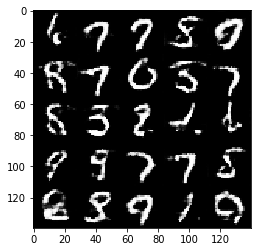

Epoch 2/2... Discriminator Loss: 1.2550... Generator Loss: 0.8028
Epoch 2/2... Discriminator Loss: 0.7779... Generator Loss: 1.4520
Epoch 2/2... Discriminator Loss: 1.3767... Generator Loss: 0.4176
Epoch 2/2... Discriminator Loss: 1.0263... Generator Loss: 1.3393
Epoch 2/2... Discriminator Loss: 1.1802... Generator Loss: 0.7541
Epoch 2/2... Discriminator Loss: 0.9690... Generator Loss: 0.7901
Epoch 2/2... Discriminator Loss: 1.3532... Generator Loss: 0.9022
Epoch 2/2... Discriminator Loss: 1.2010... Generator Loss: 0.5671


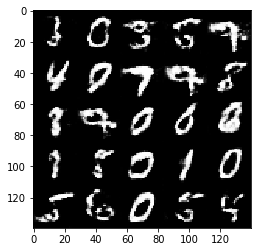

Epoch 2/2... Discriminator Loss: 1.7418... Generator Loss: 0.3751
Epoch 2/2... Discriminator Loss: 0.9687... Generator Loss: 1.7343
Epoch 2/2... Discriminator Loss: 1.2270... Generator Loss: 0.5697
Epoch 2/2... Discriminator Loss: 1.0640... Generator Loss: 0.6934
Epoch 2/2... Discriminator Loss: 2.1063... Generator Loss: 0.6082
Epoch 2/2... Discriminator Loss: 1.0059... Generator Loss: 0.9891
Epoch 2/2... Discriminator Loss: 1.1076... Generator Loss: 0.8242


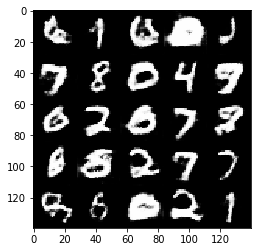

Epoch 2/2... Discriminator Loss: 1.0956... Generator Loss: 1.2214
Epoch 2/2... Discriminator Loss: 0.8725... Generator Loss: 1.0512
Epoch 2/2... Discriminator Loss: 0.8765... Generator Loss: 1.4137
Epoch 2/2... Discriminator Loss: 1.0104... Generator Loss: 0.5965
Epoch 2/2... Discriminator Loss: 0.7372... Generator Loss: 1.0662
Epoch 2/2... Discriminator Loss: 1.6337... Generator Loss: 0.5910
Epoch 2/2... Discriminator Loss: 0.5818... Generator Loss: 0.8317
Epoch 2/2... Discriminator Loss: 1.0633... Generator Loss: 2.1700


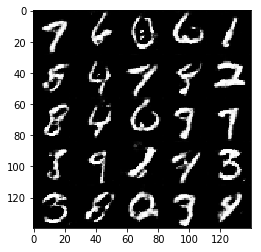

Epoch 2/2... Discriminator Loss: 1.2217... Generator Loss: 0.3536
Epoch 2/2... Discriminator Loss: 1.0390... Generator Loss: 1.0547
Epoch 2/2... Discriminator Loss: 1.5193... Generator Loss: 0.7392
Epoch 2/2... Discriminator Loss: 1.0826... Generator Loss: 1.1984
Epoch 2/2... Discriminator Loss: 1.2086... Generator Loss: 1.0438
Epoch 2/2... Discriminator Loss: 1.4550... Generator Loss: 0.7254
Epoch 2/2... Discriminator Loss: 2.4351... Generator Loss: 0.2501


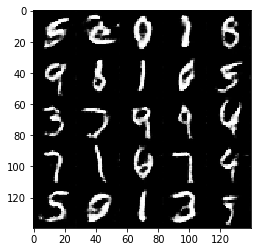

Epoch 2/2... Discriminator Loss: 1.1217... Generator Loss: 0.9464
Epoch 2/2... Discriminator Loss: 1.0269... Generator Loss: 1.3100
Epoch 2/2... Discriminator Loss: 1.6021... Generator Loss: 0.6210
Epoch 2/2... Discriminator Loss: 0.8541... Generator Loss: 0.9520
Epoch 2/2... Discriminator Loss: 0.3341... Generator Loss: 1.1763
Epoch 2/2... Discriminator Loss: 0.3386... Generator Loss: 0.5184
Epoch 2/2... Discriminator Loss: 1.9990... Generator Loss: 0.2458
Epoch 2/2... Discriminator Loss: 1.2833... Generator Loss: 1.3073


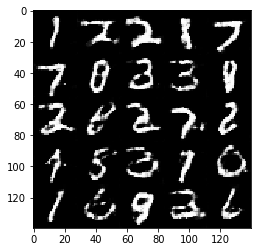

Epoch 2/2... Discriminator Loss: 0.9923... Generator Loss: 0.8059
Epoch 2/2... Discriminator Loss: 0.9002... Generator Loss: 1.4636
Epoch 2/2... Discriminator Loss: 1.3209... Generator Loss: 0.8256
Epoch 2/2... Discriminator Loss: 0.3765... Generator Loss: 0.9677
Epoch 2/2... Discriminator Loss: 1.0408... Generator Loss: 0.9067
Epoch 2/2... Discriminator Loss: 1.8366... Generator Loss: 0.2548
Epoch 2/2... Discriminator Loss: 1.2051... Generator Loss: 0.8309


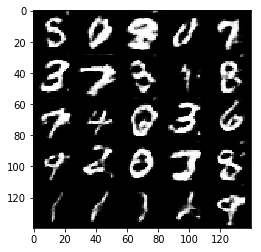

Epoch 2/2... Discriminator Loss: 1.6143... Generator Loss: 0.6991
Epoch 2/2... Discriminator Loss: 0.7535... Generator Loss: 0.8064
Epoch 2/2... Discriminator Loss: 0.3305... Generator Loss: 0.5873
Epoch 2/2... Discriminator Loss: 1.1375... Generator Loss: 1.1432
Epoch 2/2... Discriminator Loss: 1.3745... Generator Loss: 0.8547
Epoch 2/2... Discriminator Loss: 1.2983... Generator Loss: 0.8570
Epoch 2/2... Discriminator Loss: 1.1251... Generator Loss: 0.5700
Epoch 2/2... Discriminator Loss: 0.5429... Generator Loss: 1.2743


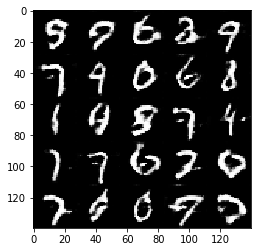

Epoch 2/2... Discriminator Loss: 1.1758... Generator Loss: 0.8706
Epoch 2/2... Discriminator Loss: 1.2373... Generator Loss: 0.3412
Epoch 2/2... Discriminator Loss: 0.9075... Generator Loss: 1.0431
Epoch 2/2... Discriminator Loss: 1.5538... Generator Loss: 0.6951
Epoch 2/2... Discriminator Loss: 1.3190... Generator Loss: 0.3425
Epoch 2/2... Discriminator Loss: 1.0125... Generator Loss: 0.8786
Epoch 2/2... Discriminator Loss: 0.9051... Generator Loss: 0.7291


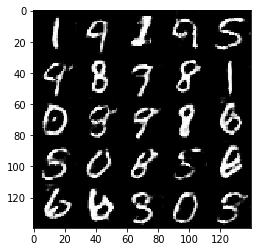

Epoch 2/2... Discriminator Loss: 1.0395... Generator Loss: 1.2300
Epoch 2/2... Discriminator Loss: 0.4915... Generator Loss: 0.8554
Epoch 2/2... Discriminator Loss: 1.3140... Generator Loss: 0.6020
Epoch 2/2... Discriminator Loss: 0.8532... Generator Loss: 1.2280
Epoch 2/2... Discriminator Loss: 0.9021... Generator Loss: 1.1920
Epoch 2/2... Discriminator Loss: 1.1955... Generator Loss: 0.6162
Epoch 2/2... Discriminator Loss: 0.8079... Generator Loss: 0.4833
Epoch 2/2... Discriminator Loss: 1.1577... Generator Loss: 0.2964


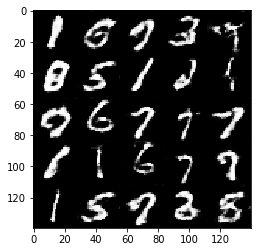

Epoch 2/2... Discriminator Loss: 1.2102... Generator Loss: 0.4713
Epoch 2/2... Discriminator Loss: 1.7432... Generator Loss: 0.5267
Epoch 2/2... Discriminator Loss: 0.8280... Generator Loss: 1.9568
Epoch 2/2... Discriminator Loss: 1.1308... Generator Loss: 0.9939
Epoch 2/2... Discriminator Loss: 1.2328... Generator Loss: 0.7090
Epoch 2/2... Discriminator Loss: 1.3206... Generator Loss: 0.5661
Epoch 2/2... Discriminator Loss: 0.9243... Generator Loss: 0.7105


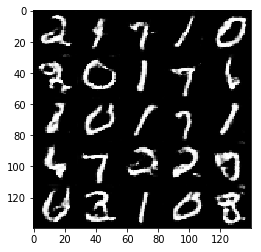

Epoch 2/2... Discriminator Loss: 1.8686... Generator Loss: 0.6122
Epoch 2/2... Discriminator Loss: 1.3396... Generator Loss: 1.1830
Epoch 2/2... Discriminator Loss: 1.2001... Generator Loss: 0.7074
Epoch 2/2... Discriminator Loss: 0.6410... Generator Loss: 0.6942
Epoch 2/2... Discriminator Loss: 0.6713... Generator Loss: 0.6069
Epoch 2/2... Discriminator Loss: 1.2729... Generator Loss: 1.0026
Epoch 2/2... Discriminator Loss: 2.3459... Generator Loss: 0.3520
Epoch 2/2... Discriminator Loss: 1.3692... Generator Loss: 0.6305


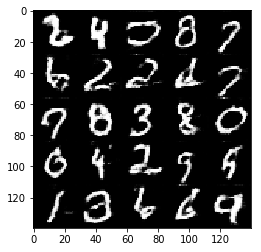

Epoch 2/2... Discriminator Loss: 0.8329... Generator Loss: 0.7910
Epoch 2/2... Discriminator Loss: 1.0594... Generator Loss: 0.8181
Epoch 2/2... Discriminator Loss: 1.9056... Generator Loss: 0.5963
Epoch 2/2... Discriminator Loss: 1.7980... Generator Loss: 0.5504
Epoch 2/2... Discriminator Loss: 1.1544... Generator Loss: 0.7500
Epoch 2/2... Discriminator Loss: 1.0379... Generator Loss: 1.2740
Epoch 2/2... Discriminator Loss: 1.2646... Generator Loss: 0.7151


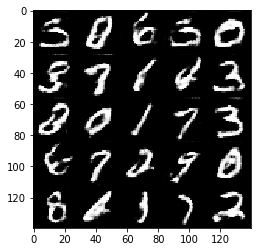

Epoch 2/2... Discriminator Loss: 1.2962... Generator Loss: 0.7237
Epoch 2/2... Discriminator Loss: 0.9194... Generator Loss: 0.7743
Epoch 2/2... Discriminator Loss: 1.4202... Generator Loss: 0.3881
Epoch 2/2... Discriminator Loss: 1.5494... Generator Loss: 0.8742
Epoch 2/2... Discriminator Loss: 1.0089... Generator Loss: 1.1075
Epoch 2/2... Discriminator Loss: 0.7820... Generator Loss: 0.7687
Epoch 2/2... Discriminator Loss: 0.9366... Generator Loss: 0.8136
Epoch 2/2... Discriminator Loss: 0.5046... Generator Loss: 0.7063


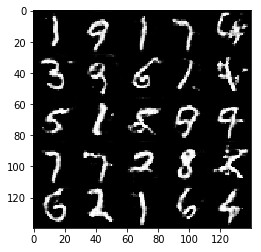

Epoch 2/2... Discriminator Loss: 2.2485... Generator Loss: 0.5031
Epoch 2/2... Discriminator Loss: 1.6433... Generator Loss: 0.3106
Epoch 2/2... Discriminator Loss: 0.5520... Generator Loss: 0.4649
Epoch 2/2... Discriminator Loss: 0.9097... Generator Loss: 1.2270
Epoch 2/2... Discriminator Loss: 1.2830... Generator Loss: 0.3409
Epoch 2/2... Discriminator Loss: 1.2854... Generator Loss: 0.4495
Epoch 2/2... Discriminator Loss: 0.9690... Generator Loss: 1.0743


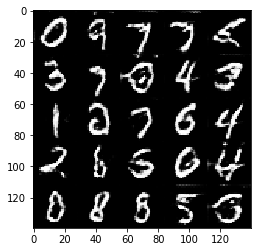

Epoch 2/2... Discriminator Loss: 1.0901... Generator Loss: 1.2331
Epoch 2/2... Discriminator Loss: 1.7195... Generator Loss: 0.4274
Epoch 2/2... Discriminator Loss: 0.6334... Generator Loss: 1.4832
Epoch 2/2... Discriminator Loss: 1.3761... Generator Loss: 1.1150
Epoch 2/2... Discriminator Loss: 1.1933... Generator Loss: 1.5284
Epoch 2/2... Discriminator Loss: 0.9293... Generator Loss: 0.7608
Epoch 2/2... Discriminator Loss: 1.0333... Generator Loss: 0.6686
Epoch 2/2... Discriminator Loss: 1.7709... Generator Loss: 0.3830


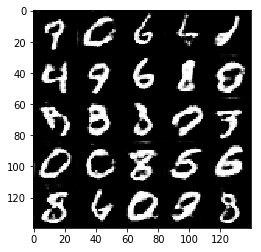

Epoch 2/2... Discriminator Loss: 1.5599... Generator Loss: 0.9561
Epoch 2/2... Discriminator Loss: 0.6915... Generator Loss: 1.7960
Epoch 2/2... Discriminator Loss: 0.6502... Generator Loss: 2.4236
Epoch 2/2... Discriminator Loss: 1.3140... Generator Loss: 0.6642
Epoch 2/2... Discriminator Loss: 1.9424... Generator Loss: 0.4013
Epoch 2/2... Discriminator Loss: 1.2974... Generator Loss: 0.7529
Epoch 2/2... Discriminator Loss: 1.1606... Generator Loss: 0.7405


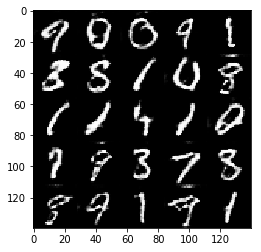

Epoch 2/2... Discriminator Loss: 1.4056... Generator Loss: 0.5927
Epoch 2/2... Discriminator Loss: 2.8790... Generator Loss: -0.2049
Epoch 2/2... Discriminator Loss: 0.5670... Generator Loss: 0.3867
Epoch 2/2... Discriminator Loss: 2.0887... Generator Loss: 0.6185
Epoch 2/2... Discriminator Loss: 0.7008... Generator Loss: 0.9150
Epoch 2/2... Discriminator Loss: 0.6800... Generator Loss: 0.5788
Epoch 2/2... Discriminator Loss: 0.9443... Generator Loss: 1.4719
Epoch 2/2... Discriminator Loss: 0.5362... Generator Loss: 0.8300


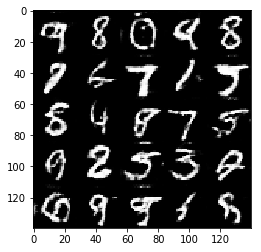

Epoch 2/2... Discriminator Loss: 1.4469... Generator Loss: 0.6976
Epoch 2/2... Discriminator Loss: 2.2789... Generator Loss: 0.5397
Epoch 2/2... Discriminator Loss: 2.9300... Generator Loss: 0.1690
Epoch 2/2... Discriminator Loss: 1.0054... Generator Loss: 0.9667
Epoch 2/2... Discriminator Loss: 1.6622... Generator Loss: 0.6139
Epoch 2/2... Discriminator Loss: 0.8463... Generator Loss: 1.4096
Epoch 2/2... Discriminator Loss: 1.0611... Generator Loss: 0.5830


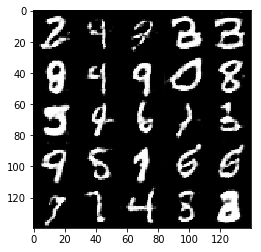

Epoch 2/2... Discriminator Loss: 1.2645... Generator Loss: 1.4499
Epoch 2/2... Discriminator Loss: 0.7870... Generator Loss: 0.8846
Epoch 2/2... Discriminator Loss: 0.6128... Generator Loss: 0.6930
Epoch 2/2... Discriminator Loss: 0.5826... Generator Loss: 0.6951
Epoch 2/2... Discriminator Loss: 1.9813... Generator Loss: 0.2314
Epoch 2/2... Discriminator Loss: 0.8061... Generator Loss: 0.5613
Epoch 2/2... Discriminator Loss: 1.3399... Generator Loss: 0.6439
Epoch 2/2... Discriminator Loss: 1.5740... Generator Loss: 0.5185


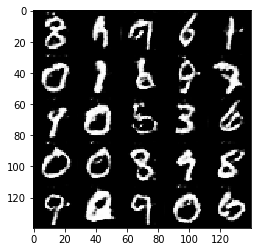

Epoch 2/2... Discriminator Loss: 1.2001... Generator Loss: 1.2466
Epoch 2/2... Discriminator Loss: 1.7338... Generator Loss: 0.2671
Epoch 2/2... Discriminator Loss: 0.5820... Generator Loss: 1.4474
Epoch 2/2... Discriminator Loss: 1.4695... Generator Loss: 0.6625
Epoch 2/2... Discriminator Loss: 0.1942... Generator Loss: 0.6670
Epoch 2/2... Discriminator Loss: 0.7941... Generator Loss: 0.6408
Epoch 2/2... Discriminator Loss: 1.7472... Generator Loss: 0.5506


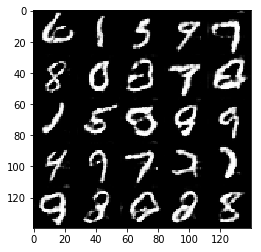

Epoch 2/2... Discriminator Loss: 0.7660... Generator Loss: 0.8242
Epoch 2/2... Discriminator Loss: 1.0651... Generator Loss: 0.5835
Epoch 2/2... Discriminator Loss: 1.4558... Generator Loss: 1.3245
Epoch 2/2... Discriminator Loss: 0.5986... Generator Loss: 0.5901
Epoch 2/2... Discriminator Loss: 1.1618... Generator Loss: 0.5737
Epoch 2/2... Discriminator Loss: 1.2938... Generator Loss: 0.5791
Epoch 2/2... Discriminator Loss: 1.4116... Generator Loss: 0.3979
Epoch 2/2... Discriminator Loss: 0.4085... Generator Loss: 0.8507


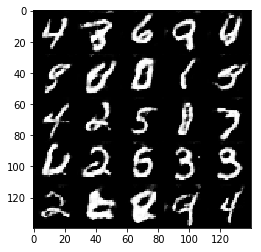

Epoch 2/2... Discriminator Loss: 1.0065... Generator Loss: 2.0954
Epoch 2/2... Discriminator Loss: 0.5097... Generator Loss: 0.3991
Epoch 2/2... Discriminator Loss: 0.8453... Generator Loss: 0.5826
Epoch 2/2... Discriminator Loss: 1.0889... Generator Loss: 0.7932
Epoch 2/2... Discriminator Loss: 0.9130... Generator Loss: 0.5998
Epoch 2/2... Discriminator Loss: 1.1843... Generator Loss: 0.5581
Epoch 2/2... Discriminator Loss: 1.5271... Generator Loss: 0.5324


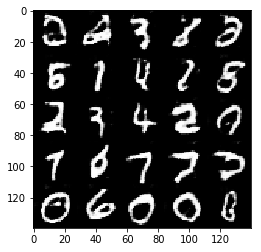

Epoch 2/2... Discriminator Loss: 1.1950... Generator Loss: 0.5456
Epoch 2/2... Discriminator Loss: 0.9235... Generator Loss: 0.6319
Epoch 2/2... Discriminator Loss: 1.4529... Generator Loss: 0.4507
Epoch 2/2... Discriminator Loss: 1.0556... Generator Loss: 1.9038
Epoch 2/2... Discriminator Loss: 0.9978... Generator Loss: 0.5686
Epoch 2/2... Discriminator Loss: 0.6528... Generator Loss: 0.7300
Epoch 2/2... Discriminator Loss: 2.1927... Generator Loss: 0.3700
Epoch 2/2... Discriminator Loss: 0.9023... Generator Loss: 1.7391


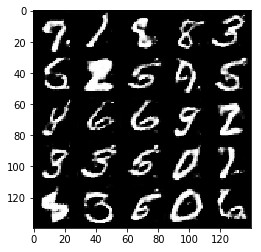

Epoch 2/2... Discriminator Loss: 1.1908... Generator Loss: 1.0223
Epoch 2/2... Discriminator Loss: 0.2294... Generator Loss: 1.0539
Epoch 2/2... Discriminator Loss: 0.7318... Generator Loss: 0.4744
Epoch 2/2... Discriminator Loss: 1.7567... Generator Loss: 0.3824
Epoch 2/2... Discriminator Loss: 1.1307... Generator Loss: 1.1509
Epoch 2/2... Discriminator Loss: 1.1906... Generator Loss: 0.7864
Epoch 2/2... Discriminator Loss: 0.9279... Generator Loss: 0.6852


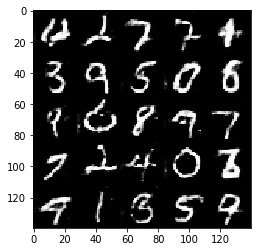

Epoch 2/2... Discriminator Loss: 1.7215... Generator Loss: 0.0254
Epoch 2/2... Discriminator Loss: 1.1497... Generator Loss: 0.6218
Epoch 2/2... Discriminator Loss: 1.2067... Generator Loss: 0.9980
Epoch 2/2... Discriminator Loss: 0.6616... Generator Loss: 0.5983
Epoch 2/2... Discriminator Loss: 0.8046... Generator Loss: 0.8527
Epoch 2/2... Discriminator Loss: 1.2136... Generator Loss: 0.6272
Epoch 2/2... Discriminator Loss: 1.0884... Generator Loss: 0.9736
Epoch 2/2... Discriminator Loss: 1.0280... Generator Loss: 1.4454


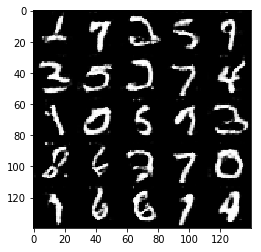

In [20]:
batch_size = 16
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.2310... Generator Loss: 10.5050
Epoch 1/1... Discriminator Loss: 3.9239... Generator Loss: -0.2782
Epoch 1/1... Discriminator Loss: 0.9439... Generator Loss: 6.7442
Epoch 1/1... Discriminator Loss: 0.6062... Generator Loss: 1.1568
Epoch 1/1... Discriminator Loss: 1.2864... Generator Loss: 8.6757
Epoch 1/1... Discriminator Loss: 0.7382... Generator Loss: 2.8518
Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.3779


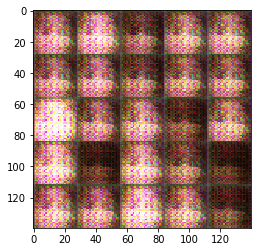

Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 0.7152
Epoch 1/1... Discriminator Loss: 0.7133... Generator Loss: 0.6426
Epoch 1/1... Discriminator Loss: 2.1264... Generator Loss: 2.8340
Epoch 1/1... Discriminator Loss: 0.4320... Generator Loss: 1.1801
Epoch 1/1... Discriminator Loss: 1.0576... Generator Loss: 0.9968
Epoch 1/1... Discriminator Loss: 1.6995... Generator Loss: 0.5082
Epoch 1/1... Discriminator Loss: 1.4680... Generator Loss: 0.9313
Epoch 1/1... Discriminator Loss: 1.4582... Generator Loss: 0.1668


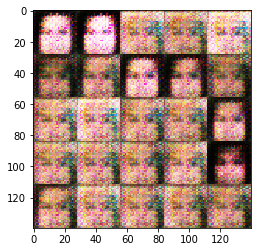

Epoch 1/1... Discriminator Loss: 0.6647... Generator Loss: 1.0276
Epoch 1/1... Discriminator Loss: 1.5696... Generator Loss: 0.6278
Epoch 1/1... Discriminator Loss: 1.2139... Generator Loss: 0.9875
Epoch 1/1... Discriminator Loss: 1.4559... Generator Loss: 1.0429
Epoch 1/1... Discriminator Loss: 1.2159... Generator Loss: 0.6932
Epoch 1/1... Discriminator Loss: 1.1621... Generator Loss: 1.6857
Epoch 1/1... Discriminator Loss: 1.9049... Generator Loss: 0.6048


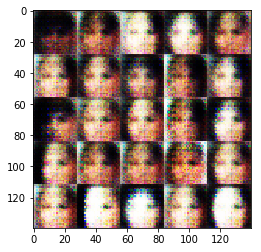

Epoch 1/1... Discriminator Loss: 1.7949... Generator Loss: 0.5538
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.9265
Epoch 1/1... Discriminator Loss: 1.9657... Generator Loss: 0.3521
Epoch 1/1... Discriminator Loss: 1.0072... Generator Loss: 2.3053
Epoch 1/1... Discriminator Loss: 1.2468... Generator Loss: 2.0704
Epoch 1/1... Discriminator Loss: 1.3658... Generator Loss: 1.0921
Epoch 1/1... Discriminator Loss: 1.2493... Generator Loss: 0.5839
Epoch 1/1... Discriminator Loss: 1.1551... Generator Loss: 0.6694


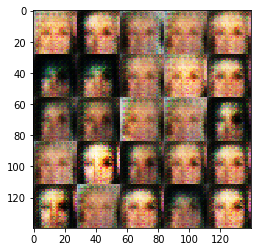

Epoch 1/1... Discriminator Loss: 1.2174... Generator Loss: 0.7836
Epoch 1/1... Discriminator Loss: 1.9017... Generator Loss: 0.4378
Epoch 1/1... Discriminator Loss: 1.0863... Generator Loss: 0.3118
Epoch 1/1... Discriminator Loss: 1.5941... Generator Loss: 0.6267
Epoch 1/1... Discriminator Loss: 0.9428... Generator Loss: 1.0070
Epoch 1/1... Discriminator Loss: 1.3289... Generator Loss: 0.7684
Epoch 1/1... Discriminator Loss: 1.2485... Generator Loss: 0.7559


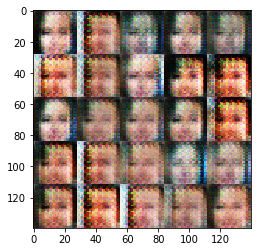

Epoch 1/1... Discriminator Loss: 0.7322... Generator Loss: 1.4567
Epoch 1/1... Discriminator Loss: 1.3276... Generator Loss: 0.3631
Epoch 1/1... Discriminator Loss: 0.9773... Generator Loss: 0.5834
Epoch 1/1... Discriminator Loss: 1.6508... Generator Loss: 0.0858
Epoch 1/1... Discriminator Loss: 1.3589... Generator Loss: 0.6055
Epoch 1/1... Discriminator Loss: 1.2833... Generator Loss: 0.7221
Epoch 1/1... Discriminator Loss: 1.1881... Generator Loss: 0.7536
Epoch 1/1... Discriminator Loss: 1.1528... Generator Loss: 0.8638


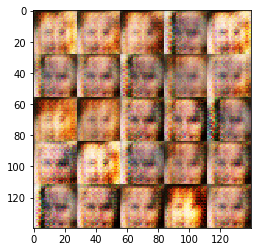

Epoch 1/1... Discriminator Loss: 0.9088... Generator Loss: 0.6449
Epoch 1/1... Discriminator Loss: 1.9126... Generator Loss: 1.5736
Epoch 1/1... Discriminator Loss: 1.9348... Generator Loss: 1.7530
Epoch 1/1... Discriminator Loss: 1.0820... Generator Loss: 0.5016
Epoch 1/1... Discriminator Loss: 1.8376... Generator Loss: 0.3659
Epoch 1/1... Discriminator Loss: 0.4099... Generator Loss: 1.4984
Epoch 1/1... Discriminator Loss: 2.2858... Generator Loss: 0.2094


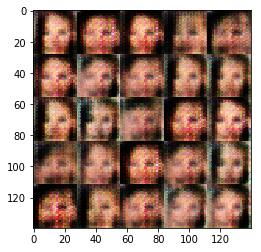

Epoch 1/1... Discriminator Loss: 1.9706... Generator Loss: 0.5394
Epoch 1/1... Discriminator Loss: 1.3641... Generator Loss: 0.5601
Epoch 1/1... Discriminator Loss: 1.3209... Generator Loss: 0.7984
Epoch 1/1... Discriminator Loss: 1.2928... Generator Loss: 0.6739
Epoch 1/1... Discriminator Loss: 0.9812... Generator Loss: 1.4791
Epoch 1/1... Discriminator Loss: 1.1353... Generator Loss: 0.5700
Epoch 1/1... Discriminator Loss: 1.5587... Generator Loss: 0.1479
Epoch 1/1... Discriminator Loss: 1.2393... Generator Loss: 0.7317


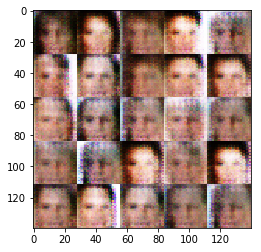

Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 0.6211
Epoch 1/1... Discriminator Loss: 0.9041... Generator Loss: 0.8034
Epoch 1/1... Discriminator Loss: 1.5388... Generator Loss: 0.4408
Epoch 1/1... Discriminator Loss: 1.3194... Generator Loss: 0.5765
Epoch 1/1... Discriminator Loss: 1.4940... Generator Loss: 0.5941
Epoch 1/1... Discriminator Loss: 1.2508... Generator Loss: 0.7095
Epoch 1/1... Discriminator Loss: 0.8283... Generator Loss: 1.1428


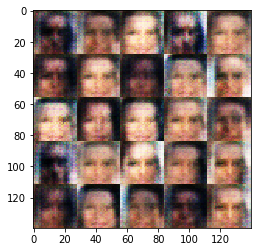

Epoch 1/1... Discriminator Loss: 1.1517... Generator Loss: 0.4682
Epoch 1/1... Discriminator Loss: 1.0583... Generator Loss: 0.3884
Epoch 1/1... Discriminator Loss: 1.2677... Generator Loss: 0.4692
Epoch 1/1... Discriminator Loss: 1.2513... Generator Loss: 1.2900
Epoch 1/1... Discriminator Loss: 0.8851... Generator Loss: 0.7085
Epoch 1/1... Discriminator Loss: 1.3379... Generator Loss: 0.8002
Epoch 1/1... Discriminator Loss: 1.2402... Generator Loss: 0.8355
Epoch 1/1... Discriminator Loss: 1.1784... Generator Loss: 0.4023


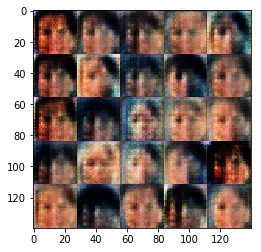

Epoch 1/1... Discriminator Loss: 1.3198... Generator Loss: 0.5547
Epoch 1/1... Discriminator Loss: 1.4398... Generator Loss: 0.7002
Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.5298
Epoch 1/1... Discriminator Loss: 1.0478... Generator Loss: 0.8709
Epoch 1/1... Discriminator Loss: 0.8648... Generator Loss: 0.9978
Epoch 1/1... Discriminator Loss: 0.9513... Generator Loss: 0.9172
Epoch 1/1... Discriminator Loss: 1.2157... Generator Loss: 0.7141


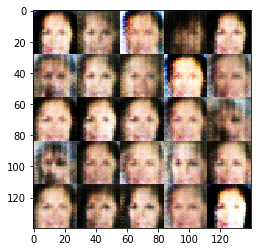

Epoch 1/1... Discriminator Loss: 1.1794... Generator Loss: 0.6482
Epoch 1/1... Discriminator Loss: 0.9613... Generator Loss: 0.8629
Epoch 1/1... Discriminator Loss: 1.1641... Generator Loss: 0.8298
Epoch 1/1... Discriminator Loss: 0.6329... Generator Loss: 0.8928
Epoch 1/1... Discriminator Loss: 1.2028... Generator Loss: 1.1121
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.6171
Epoch 1/1... Discriminator Loss: 1.1934... Generator Loss: 0.9763
Epoch 1/1... Discriminator Loss: 1.5398... Generator Loss: 0.5986


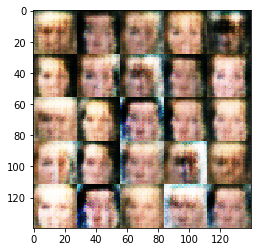

Epoch 1/1... Discriminator Loss: 1.3467... Generator Loss: 0.5636
Epoch 1/1... Discriminator Loss: 1.2626... Generator Loss: 1.2681
Epoch 1/1... Discriminator Loss: 1.2548... Generator Loss: 0.7262
Epoch 1/1... Discriminator Loss: 1.0995... Generator Loss: 0.4533
Epoch 1/1... Discriminator Loss: 1.1540... Generator Loss: 0.5691
Epoch 1/1... Discriminator Loss: 0.8693... Generator Loss: 0.7262
Epoch 1/1... Discriminator Loss: 1.1782... Generator Loss: 0.4916


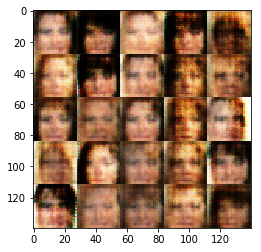

Epoch 1/1... Discriminator Loss: 1.3182... Generator Loss: 0.7432
Epoch 1/1... Discriminator Loss: 1.4747... Generator Loss: 0.5818
Epoch 1/1... Discriminator Loss: 1.2959... Generator Loss: 0.8822
Epoch 1/1... Discriminator Loss: 0.9631... Generator Loss: 0.9805
Epoch 1/1... Discriminator Loss: 0.9406... Generator Loss: 1.1203
Epoch 1/1... Discriminator Loss: 1.0954... Generator Loss: 0.4872
Epoch 1/1... Discriminator Loss: 1.2423... Generator Loss: 0.4598
Epoch 1/1... Discriminator Loss: 1.7292... Generator Loss: 0.1712


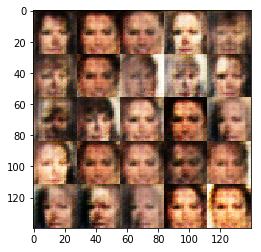

Epoch 1/1... Discriminator Loss: 1.0440... Generator Loss: 0.8165
Epoch 1/1... Discriminator Loss: 1.3449... Generator Loss: 0.5660
Epoch 1/1... Discriminator Loss: 1.4594... Generator Loss: 0.4533
Epoch 1/1... Discriminator Loss: 1.1872... Generator Loss: 0.2940
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.5972
Epoch 1/1... Discriminator Loss: 1.2702... Generator Loss: 0.5171
Epoch 1/1... Discriminator Loss: 1.3013... Generator Loss: 0.7617


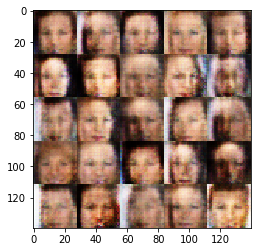

Epoch 1/1... Discriminator Loss: 1.4583... Generator Loss: 0.4591
Epoch 1/1... Discriminator Loss: 0.9912... Generator Loss: 0.7546
Epoch 1/1... Discriminator Loss: 1.2289... Generator Loss: 0.4897
Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 0.4620
Epoch 1/1... Discriminator Loss: 1.5247... Generator Loss: 0.3887
Epoch 1/1... Discriminator Loss: 1.7196... Generator Loss: 0.3410
Epoch 1/1... Discriminator Loss: 1.1164... Generator Loss: 0.7450
Epoch 1/1... Discriminator Loss: 1.1702... Generator Loss: 1.1796


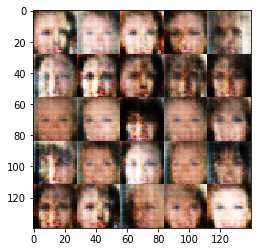

Epoch 1/1... Discriminator Loss: 1.4575... Generator Loss: 0.4278
Epoch 1/1... Discriminator Loss: 1.0920... Generator Loss: 0.7776
Epoch 1/1... Discriminator Loss: 1.3469... Generator Loss: 0.7900
Epoch 1/1... Discriminator Loss: 2.4779... Generator Loss: -0.0733
Epoch 1/1... Discriminator Loss: 1.2203... Generator Loss: 0.4932
Epoch 1/1... Discriminator Loss: 1.3303... Generator Loss: 0.5644
Epoch 1/1... Discriminator Loss: 1.5127... Generator Loss: 0.6389


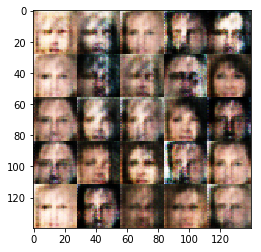

Epoch 1/1... Discriminator Loss: 1.1088... Generator Loss: 1.1226
Epoch 1/1... Discriminator Loss: 1.2459... Generator Loss: 0.7684
Epoch 1/1... Discriminator Loss: 0.7747... Generator Loss: 0.6792
Epoch 1/1... Discriminator Loss: 1.1411... Generator Loss: 0.7226
Epoch 1/1... Discriminator Loss: 1.1474... Generator Loss: 0.7002
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.3011
Epoch 1/1... Discriminator Loss: 1.0469... Generator Loss: 0.5623
Epoch 1/1... Discriminator Loss: 0.8170... Generator Loss: 0.4966


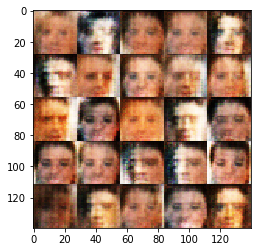

Epoch 1/1... Discriminator Loss: 1.7508... Generator Loss: 0.4137
Epoch 1/1... Discriminator Loss: 1.1635... Generator Loss: 0.7120
Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.7664
Epoch 1/1... Discriminator Loss: 1.4857... Generator Loss: 0.6194
Epoch 1/1... Discriminator Loss: 1.2673... Generator Loss: 0.9270
Epoch 1/1... Discriminator Loss: 1.1998... Generator Loss: 0.8409
Epoch 1/1... Discriminator Loss: 1.1968... Generator Loss: 1.0306


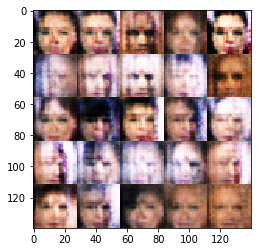

Epoch 1/1... Discriminator Loss: 1.0181... Generator Loss: 1.3270
Epoch 1/1... Discriminator Loss: 1.8623... Generator Loss: 0.4181
Epoch 1/1... Discriminator Loss: 1.2684... Generator Loss: 0.8861
Epoch 1/1... Discriminator Loss: 1.1986... Generator Loss: 0.7118
Epoch 1/1... Discriminator Loss: 1.3056... Generator Loss: 0.4033
Epoch 1/1... Discriminator Loss: 1.2971... Generator Loss: 0.7063
Epoch 1/1... Discriminator Loss: 1.4622... Generator Loss: 0.2871
Epoch 1/1... Discriminator Loss: 0.8154... Generator Loss: 1.4658


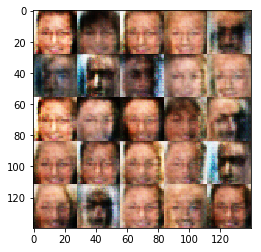

Epoch 1/1... Discriminator Loss: 1.6298... Generator Loss: 0.3476
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.8058
Epoch 1/1... Discriminator Loss: 0.9843... Generator Loss: 0.6286
Epoch 1/1... Discriminator Loss: 1.0864... Generator Loss: 0.8138
Epoch 1/1... Discriminator Loss: 1.5187... Generator Loss: 0.6345
Epoch 1/1... Discriminator Loss: 1.2261... Generator Loss: 1.5271
Epoch 1/1... Discriminator Loss: 1.2731... Generator Loss: 0.8203


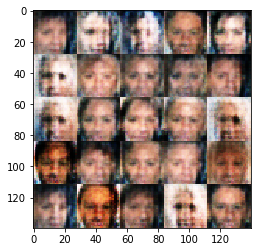

Epoch 1/1... Discriminator Loss: 0.8438... Generator Loss: 0.7942
Epoch 1/1... Discriminator Loss: 1.9400... Generator Loss: 0.4602
Epoch 1/1... Discriminator Loss: 1.1647... Generator Loss: 0.4082
Epoch 1/1... Discriminator Loss: 1.0642... Generator Loss: 0.8767
Epoch 1/1... Discriminator Loss: 1.1458... Generator Loss: 0.6766
Epoch 1/1... Discriminator Loss: 1.2415... Generator Loss: 0.5546
Epoch 1/1... Discriminator Loss: 1.1865... Generator Loss: 0.4443
Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.8214


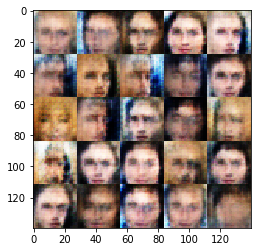

Epoch 1/1... Discriminator Loss: 1.7907... Generator Loss: 0.8052
Epoch 1/1... Discriminator Loss: 1.2799... Generator Loss: 0.3445
Epoch 1/1... Discriminator Loss: 1.2258... Generator Loss: 0.6707
Epoch 1/1... Discriminator Loss: 1.1178... Generator Loss: 1.0367
Epoch 1/1... Discriminator Loss: 1.0625... Generator Loss: 0.7886
Epoch 1/1... Discriminator Loss: 1.1906... Generator Loss: 0.6956
Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.5738


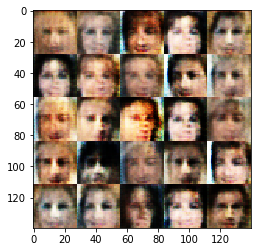

Epoch 1/1... Discriminator Loss: 1.2479... Generator Loss: 0.8511
Epoch 1/1... Discriminator Loss: 1.6124... Generator Loss: 0.6034
Epoch 1/1... Discriminator Loss: 1.2619... Generator Loss: 0.7356
Epoch 1/1... Discriminator Loss: 1.3445... Generator Loss: 0.6060
Epoch 1/1... Discriminator Loss: 1.1077... Generator Loss: 0.9260
Epoch 1/1... Discriminator Loss: 1.2117... Generator Loss: 0.4612
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.6868
Epoch 1/1... Discriminator Loss: 1.2046... Generator Loss: 0.9324


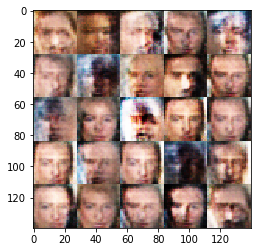

Epoch 1/1... Discriminator Loss: 1.2041... Generator Loss: 0.6142
Epoch 1/1... Discriminator Loss: 1.3029... Generator Loss: 0.8106
Epoch 1/1... Discriminator Loss: 1.2642... Generator Loss: 0.8176
Epoch 1/1... Discriminator Loss: 1.3129... Generator Loss: 0.7189
Epoch 1/1... Discriminator Loss: 1.3675... Generator Loss: 0.5610
Epoch 1/1... Discriminator Loss: 0.7643... Generator Loss: 0.8013
Epoch 1/1... Discriminator Loss: 0.7561... Generator Loss: 0.6909


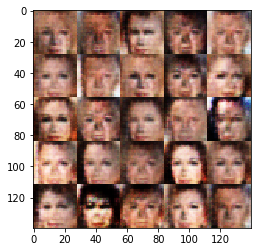

Epoch 1/1... Discriminator Loss: 1.8833... Generator Loss: 0.2398
Epoch 1/1... Discriminator Loss: 1.7356... Generator Loss: 0.3702
Epoch 1/1... Discriminator Loss: 1.2751... Generator Loss: 0.1739
Epoch 1/1... Discriminator Loss: 1.3656... Generator Loss: 0.6773
Epoch 1/1... Discriminator Loss: 1.2330... Generator Loss: 0.7809
Epoch 1/1... Discriminator Loss: 1.1263... Generator Loss: 0.9528
Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.4834
Epoch 1/1... Discriminator Loss: 1.2702... Generator Loss: 1.2691


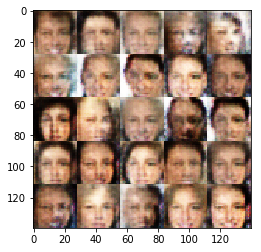

Epoch 1/1... Discriminator Loss: 0.8564... Generator Loss: 0.9873
Epoch 1/1... Discriminator Loss: 1.3454... Generator Loss: 0.7444
Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 0.5558
Epoch 1/1... Discriminator Loss: 1.5323... Generator Loss: 0.5069
Epoch 1/1... Discriminator Loss: 1.0323... Generator Loss: 0.9894
Epoch 1/1... Discriminator Loss: 1.3439... Generator Loss: 0.7271
Epoch 1/1... Discriminator Loss: 1.4837... Generator Loss: 0.7139


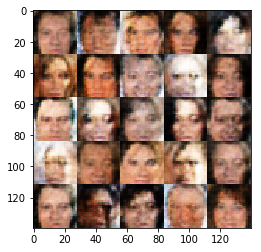

Epoch 1/1... Discriminator Loss: 1.1336... Generator Loss: 1.5453
Epoch 1/1... Discriminator Loss: 1.0904... Generator Loss: 0.5732
Epoch 1/1... Discriminator Loss: 1.7956... Generator Loss: 0.4248
Epoch 1/1... Discriminator Loss: 1.0981... Generator Loss: 0.5678
Epoch 1/1... Discriminator Loss: 1.1488... Generator Loss: 0.6261
Epoch 1/1... Discriminator Loss: 0.9213... Generator Loss: 0.9861
Epoch 1/1... Discriminator Loss: 1.2101... Generator Loss: 0.5354
Epoch 1/1... Discriminator Loss: 1.2213... Generator Loss: 0.6648


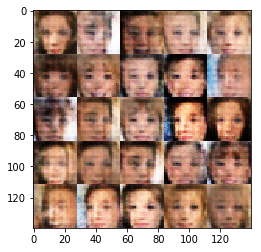

Epoch 1/1... Discriminator Loss: 1.0540... Generator Loss: 0.8920
Epoch 1/1... Discriminator Loss: 1.0218... Generator Loss: 1.1256
Epoch 1/1... Discriminator Loss: 1.4206... Generator Loss: 1.1131
Epoch 1/1... Discriminator Loss: 1.2646... Generator Loss: 0.8907
Epoch 1/1... Discriminator Loss: 0.8351... Generator Loss: 0.8321
Epoch 1/1... Discriminator Loss: 1.3358... Generator Loss: 0.2734
Epoch 1/1... Discriminator Loss: 0.7760... Generator Loss: 1.1468


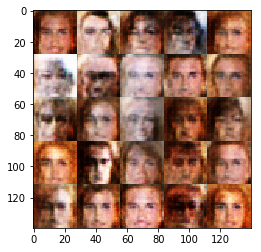

Epoch 1/1... Discriminator Loss: 1.3060... Generator Loss: 0.6218
Epoch 1/1... Discriminator Loss: 1.5450... Generator Loss: 0.6370
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.6034
Epoch 1/1... Discriminator Loss: 1.2734... Generator Loss: 0.8301
Epoch 1/1... Discriminator Loss: 1.4963... Generator Loss: 0.6304
Epoch 1/1... Discriminator Loss: 1.5846... Generator Loss: 0.6022
Epoch 1/1... Discriminator Loss: 1.2993... Generator Loss: 0.5166
Epoch 1/1... Discriminator Loss: 1.3113... Generator Loss: 0.7265


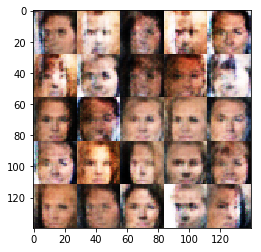

Epoch 1/1... Discriminator Loss: 0.6915... Generator Loss: 0.3727
Epoch 1/1... Discriminator Loss: 1.2215... Generator Loss: 1.2179
Epoch 1/1... Discriminator Loss: 0.8961... Generator Loss: 0.8710
Epoch 1/1... Discriminator Loss: 0.9343... Generator Loss: 1.0325
Epoch 1/1... Discriminator Loss: 1.2619... Generator Loss: 0.3802
Epoch 1/1... Discriminator Loss: 1.2684... Generator Loss: 0.6378
Epoch 1/1... Discriminator Loss: 1.2080... Generator Loss: 0.6587


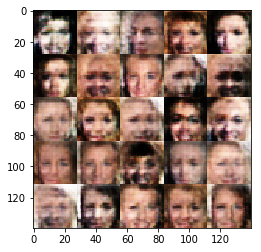

Epoch 1/1... Discriminator Loss: 1.3120... Generator Loss: 0.2800
Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 0.5150
Epoch 1/1... Discriminator Loss: 0.7886... Generator Loss: 0.8551
Epoch 1/1... Discriminator Loss: 1.3030... Generator Loss: 0.9816
Epoch 1/1... Discriminator Loss: 1.3233... Generator Loss: 0.9833
Epoch 1/1... Discriminator Loss: 1.2822... Generator Loss: 0.4924
Epoch 1/1... Discriminator Loss: 1.1659... Generator Loss: 1.1010
Epoch 1/1... Discriminator Loss: 0.9887... Generator Loss: 0.2732


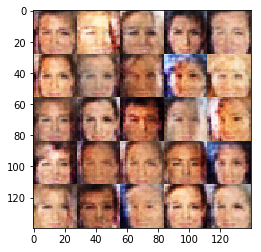

Epoch 1/1... Discriminator Loss: 1.5984... Generator Loss: 0.2393
Epoch 1/1... Discriminator Loss: 1.2804... Generator Loss: 0.9272
Epoch 1/1... Discriminator Loss: 1.1473... Generator Loss: 0.6281
Epoch 1/1... Discriminator Loss: 1.3473... Generator Loss: 0.6178
Epoch 1/1... Discriminator Loss: 1.4444... Generator Loss: 0.4778
Epoch 1/1... Discriminator Loss: 1.3750... Generator Loss: 0.9457
Epoch 1/1... Discriminator Loss: 0.7541... Generator Loss: 0.7657


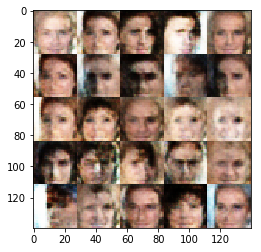

Epoch 1/1... Discriminator Loss: 0.4649... Generator Loss: 0.6970
Epoch 1/1... Discriminator Loss: 1.1987... Generator Loss: 1.0565
Epoch 1/1... Discriminator Loss: 1.2864... Generator Loss: 0.6920
Epoch 1/1... Discriminator Loss: 1.2162... Generator Loss: 0.5832
Epoch 1/1... Discriminator Loss: 1.2444... Generator Loss: 1.0549
Epoch 1/1... Discriminator Loss: 1.3218... Generator Loss: 0.8228
Epoch 1/1... Discriminator Loss: 1.0126... Generator Loss: 0.9564
Epoch 1/1... Discriminator Loss: 0.9570... Generator Loss: 0.9453


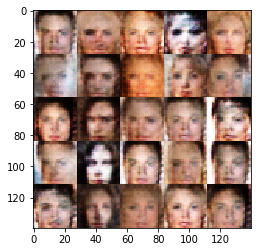

Epoch 1/1... Discriminator Loss: 1.1782... Generator Loss: 0.5983
Epoch 1/1... Discriminator Loss: 0.8580... Generator Loss: 0.5762
Epoch 1/1... Discriminator Loss: 0.4495... Generator Loss: 1.7661
Epoch 1/1... Discriminator Loss: 0.9868... Generator Loss: 0.5598
Epoch 1/1... Discriminator Loss: 0.6676... Generator Loss: 0.5242
Epoch 1/1... Discriminator Loss: 1.5807... Generator Loss: 0.5767
Epoch 1/1... Discriminator Loss: 1.3183... Generator Loss: 0.5939


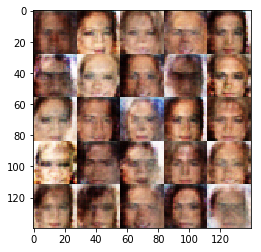

Epoch 1/1... Discriminator Loss: 1.3035... Generator Loss: 0.6081
Epoch 1/1... Discriminator Loss: 1.0743... Generator Loss: 0.3651
Epoch 1/1... Discriminator Loss: 0.8666... Generator Loss: 0.7584
Epoch 1/1... Discriminator Loss: 1.4809... Generator Loss: 0.4880
Epoch 1/1... Discriminator Loss: 2.2440... Generator Loss: 0.4478
Epoch 1/1... Discriminator Loss: 1.0409... Generator Loss: 0.8185
Epoch 1/1... Discriminator Loss: 1.6554... Generator Loss: 0.6290
Epoch 1/1... Discriminator Loss: 1.1524... Generator Loss: 0.8610


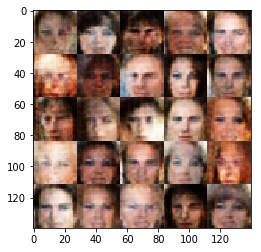

Epoch 1/1... Discriminator Loss: 1.1716... Generator Loss: 0.5960
Epoch 1/1... Discriminator Loss: 1.1557... Generator Loss: 0.6863
Epoch 1/1... Discriminator Loss: 1.1602... Generator Loss: 0.6689
Epoch 1/1... Discriminator Loss: 1.4565... Generator Loss: 0.5941
Epoch 1/1... Discriminator Loss: 1.0023... Generator Loss: 0.7780
Epoch 1/1... Discriminator Loss: 0.9933... Generator Loss: 1.2600
Epoch 1/1... Discriminator Loss: 1.0324... Generator Loss: 0.5935


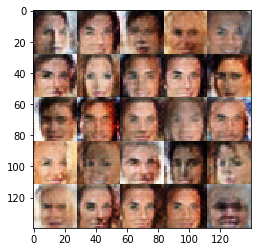

Epoch 1/1... Discriminator Loss: 1.2627... Generator Loss: 0.2538
Epoch 1/1... Discriminator Loss: 1.7053... Generator Loss: 0.4935
Epoch 1/1... Discriminator Loss: 1.0280... Generator Loss: 0.3283
Epoch 1/1... Discriminator Loss: 0.8269... Generator Loss: 0.4988
Epoch 1/1... Discriminator Loss: 1.3723... Generator Loss: 0.8119
Epoch 1/1... Discriminator Loss: 1.1558... Generator Loss: 0.6825
Epoch 1/1... Discriminator Loss: 1.0254... Generator Loss: 0.6061
Epoch 1/1... Discriminator Loss: 1.2001... Generator Loss: 1.3741


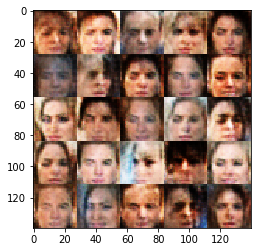

Epoch 1/1... Discriminator Loss: 0.9975... Generator Loss: 1.0789
Epoch 1/1... Discriminator Loss: 1.0815... Generator Loss: 0.8814
Epoch 1/1... Discriminator Loss: 0.8922... Generator Loss: 0.6374
Epoch 1/1... Discriminator Loss: 0.8848... Generator Loss: 0.7981
Epoch 1/1... Discriminator Loss: 1.2879... Generator Loss: 0.7172
Epoch 1/1... Discriminator Loss: 1.2918... Generator Loss: 0.7624
Epoch 1/1... Discriminator Loss: 1.4109... Generator Loss: 0.6032


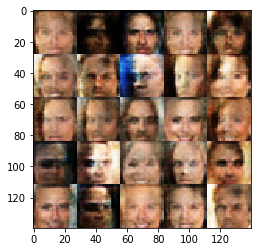

Epoch 1/1... Discriminator Loss: 0.6693... Generator Loss: 0.7779
Epoch 1/1... Discriminator Loss: 1.5111... Generator Loss: 0.6051
Epoch 1/1... Discriminator Loss: 1.1133... Generator Loss: 0.5000
Epoch 1/1... Discriminator Loss: 1.6626... Generator Loss: 0.5593
Epoch 1/1... Discriminator Loss: 0.6914... Generator Loss: 0.6299
Epoch 1/1... Discriminator Loss: 1.3572... Generator Loss: 0.5835
Epoch 1/1... Discriminator Loss: 0.9525... Generator Loss: 0.5956
Epoch 1/1... Discriminator Loss: 1.3167... Generator Loss: 0.9295


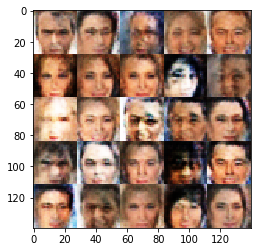

Epoch 1/1... Discriminator Loss: 1.0157... Generator Loss: 0.5919
Epoch 1/1... Discriminator Loss: 0.9542... Generator Loss: 0.9644
Epoch 1/1... Discriminator Loss: 0.9011... Generator Loss: 0.9834
Epoch 1/1... Discriminator Loss: 1.4638... Generator Loss: 0.5367
Epoch 1/1... Discriminator Loss: 1.1378... Generator Loss: 0.5752
Epoch 1/1... Discriminator Loss: 1.6206... Generator Loss: 0.6360
Epoch 1/1... Discriminator Loss: 1.3152... Generator Loss: 0.6409


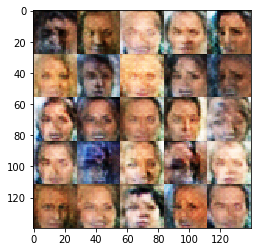

Epoch 1/1... Discriminator Loss: 1.1838... Generator Loss: 0.6225
Epoch 1/1... Discriminator Loss: 1.2538... Generator Loss: 0.9153
Epoch 1/1... Discriminator Loss: 1.7177... Generator Loss: 0.4374
Epoch 1/1... Discriminator Loss: 1.3009... Generator Loss: 0.6197
Epoch 1/1... Discriminator Loss: 0.7780... Generator Loss: 0.5534
Epoch 1/1... Discriminator Loss: 1.1895... Generator Loss: 0.9138
Epoch 1/1... Discriminator Loss: 1.2302... Generator Loss: 1.1109
Epoch 1/1... Discriminator Loss: 1.6209... Generator Loss: 0.5335


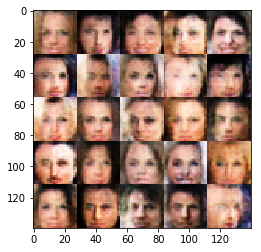

Epoch 1/1... Discriminator Loss: 1.5374... Generator Loss: 0.7551
Epoch 1/1... Discriminator Loss: 1.0159... Generator Loss: 0.6844
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 1.0385
Epoch 1/1... Discriminator Loss: 0.9450... Generator Loss: 1.1959
Epoch 1/1... Discriminator Loss: 1.4444... Generator Loss: 0.5524
Epoch 1/1... Discriminator Loss: 1.0314... Generator Loss: 0.3333
Epoch 1/1... Discriminator Loss: 1.0312... Generator Loss: 0.8968


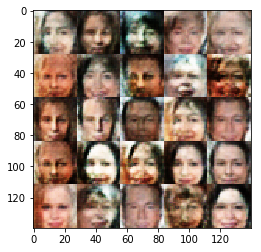

Epoch 1/1... Discriminator Loss: 1.1679... Generator Loss: 0.4575
Epoch 1/1... Discriminator Loss: 0.9880... Generator Loss: 0.5449
Epoch 1/1... Discriminator Loss: 1.0804... Generator Loss: 0.6626
Epoch 1/1... Discriminator Loss: 1.2379... Generator Loss: 0.8288
Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 0.2546
Epoch 1/1... Discriminator Loss: 1.1214... Generator Loss: 0.4194
Epoch 1/1... Discriminator Loss: 1.4707... Generator Loss: 0.4539
Epoch 1/1... Discriminator Loss: 1.4129... Generator Loss: 0.6537


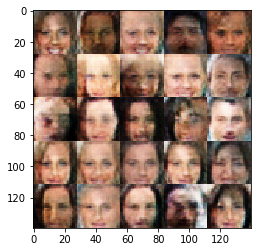

Epoch 1/1... Discriminator Loss: 1.2640... Generator Loss: 1.2986
Epoch 1/1... Discriminator Loss: 0.9188... Generator Loss: 0.5524
Epoch 1/1... Discriminator Loss: 0.5503... Generator Loss: 0.5995
Epoch 1/1... Discriminator Loss: 1.1174... Generator Loss: 0.9001
Epoch 1/1... Discriminator Loss: 1.4343... Generator Loss: 0.1912
Epoch 1/1... Discriminator Loss: 1.8737... Generator Loss: 0.4840
Epoch 1/1... Discriminator Loss: 0.6678... Generator Loss: 0.6380


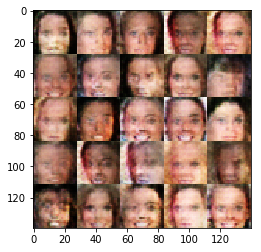

Epoch 1/1... Discriminator Loss: 1.2855... Generator Loss: 1.3351
Epoch 1/1... Discriminator Loss: 1.3036... Generator Loss: 0.8621
Epoch 1/1... Discriminator Loss: 1.4339... Generator Loss: 0.4154
Epoch 1/1... Discriminator Loss: 1.3198... Generator Loss: 0.7064
Epoch 1/1... Discriminator Loss: 1.1396... Generator Loss: 0.3869
Epoch 1/1... Discriminator Loss: 0.8788... Generator Loss: 0.6844
Epoch 1/1... Discriminator Loss: 0.7167... Generator Loss: 0.6780
Epoch 1/1... Discriminator Loss: 0.8597... Generator Loss: 0.8237


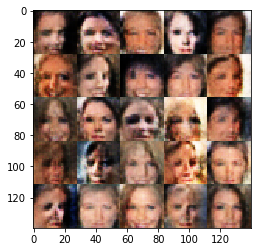

Epoch 1/1... Discriminator Loss: 1.2970... Generator Loss: 0.5681
Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.6098
Epoch 1/1... Discriminator Loss: 0.8684... Generator Loss: 0.8501
Epoch 1/1... Discriminator Loss: 1.2054... Generator Loss: 0.5507
Epoch 1/1... Discriminator Loss: 0.9144... Generator Loss: 0.4751
Epoch 1/1... Discriminator Loss: 0.5031... Generator Loss: 0.8984
Epoch 1/1... Discriminator Loss: 1.1867... Generator Loss: 0.7835


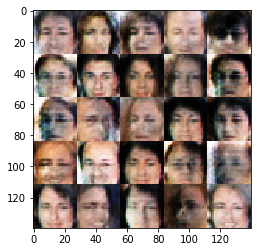

Epoch 1/1... Discriminator Loss: 0.9801... Generator Loss: 0.6544
Epoch 1/1... Discriminator Loss: 0.9120... Generator Loss: 0.3531
Epoch 1/1... Discriminator Loss: 1.3474... Generator Loss: 0.4992
Epoch 1/1... Discriminator Loss: 1.1517... Generator Loss: 0.8479
Epoch 1/1... Discriminator Loss: 1.1003... Generator Loss: 0.5889
Epoch 1/1... Discriminator Loss: 1.1080... Generator Loss: 1.7529
Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 0.5238
Epoch 1/1... Discriminator Loss: 0.6259... Generator Loss: 0.7659


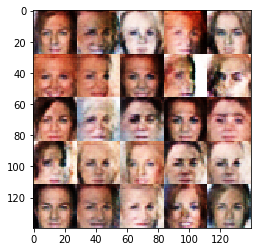

Epoch 1/1... Discriminator Loss: 1.3063... Generator Loss: 0.7345
Epoch 1/1... Discriminator Loss: 1.5200... Generator Loss: 0.5898
Epoch 1/1... Discriminator Loss: 0.7239... Generator Loss: 0.3839
Epoch 1/1... Discriminator Loss: 1.0599... Generator Loss: 1.2981
Epoch 1/1... Discriminator Loss: 1.1513... Generator Loss: 0.6790
Epoch 1/1... Discriminator Loss: 0.8053... Generator Loss: 0.7070
Epoch 1/1... Discriminator Loss: 1.0928... Generator Loss: 0.6879


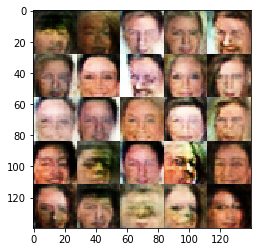

Epoch 1/1... Discriminator Loss: 1.1706... Generator Loss: 0.7844
Epoch 1/1... Discriminator Loss: 0.7084... Generator Loss: 0.8390
Epoch 1/1... Discriminator Loss: 1.0472... Generator Loss: 0.8681
Epoch 1/1... Discriminator Loss: 1.1628... Generator Loss: 0.7534
Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.6153
Epoch 1/1... Discriminator Loss: 1.1454... Generator Loss: 1.4667
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 1.1613
Epoch 1/1... Discriminator Loss: 1.0769... Generator Loss: 1.0418


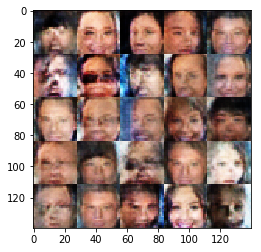

Epoch 1/1... Discriminator Loss: 1.2457... Generator Loss: 0.8017
Epoch 1/1... Discriminator Loss: 0.9199... Generator Loss: 0.9995
Epoch 1/1... Discriminator Loss: 1.1107... Generator Loss: 0.8614
Epoch 1/1... Discriminator Loss: 0.7441... Generator Loss: 1.1507
Epoch 1/1... Discriminator Loss: 1.4396... Generator Loss: 0.4549
Epoch 1/1... Discriminator Loss: 1.1613... Generator Loss: 0.9904
Epoch 1/1... Discriminator Loss: 0.6096... Generator Loss: 0.9541


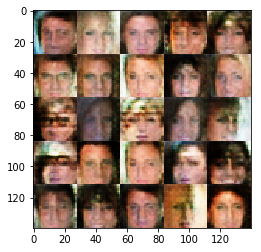

Epoch 1/1... Discriminator Loss: 0.8471... Generator Loss: 0.9599
Epoch 1/1... Discriminator Loss: 0.9994... Generator Loss: 1.2783
Epoch 1/1... Discriminator Loss: 1.6088... Generator Loss: 0.6788
Epoch 1/1... Discriminator Loss: 1.0461... Generator Loss: 0.9728
Epoch 1/1... Discriminator Loss: 1.4760... Generator Loss: 0.9098
Epoch 1/1... Discriminator Loss: 1.3093... Generator Loss: 0.6901
Epoch 1/1... Discriminator Loss: 1.1912... Generator Loss: 1.6407
Epoch 1/1... Discriminator Loss: 1.2996... Generator Loss: 0.9943


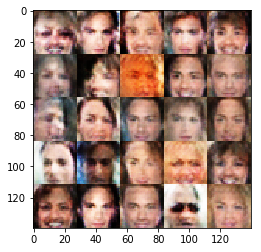

Epoch 1/1... Discriminator Loss: 1.3009... Generator Loss: 0.7256
Epoch 1/1... Discriminator Loss: 1.5321... Generator Loss: 0.3490
Epoch 1/1... Discriminator Loss: 1.1389... Generator Loss: 1.3765
Epoch 1/1... Discriminator Loss: 1.0877... Generator Loss: 0.9646
Epoch 1/1... Discriminator Loss: 1.1348... Generator Loss: 0.5200
Epoch 1/1... Discriminator Loss: 1.1594... Generator Loss: 0.6163
Epoch 1/1... Discriminator Loss: 0.9473... Generator Loss: 0.7278


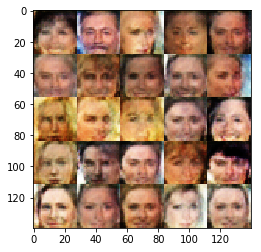

Epoch 1/1... Discriminator Loss: 1.1353... Generator Loss: 0.8819
Epoch 1/1... Discriminator Loss: 1.9583... Generator Loss: 0.3146
Epoch 1/1... Discriminator Loss: 1.2762... Generator Loss: 0.5557
Epoch 1/1... Discriminator Loss: 1.7156... Generator Loss: 0.4268
Epoch 1/1... Discriminator Loss: 1.0450... Generator Loss: 0.8684
Epoch 1/1... Discriminator Loss: 1.3504... Generator Loss: 0.6296
Epoch 1/1... Discriminator Loss: 1.1960... Generator Loss: 0.6647
Epoch 1/1... Discriminator Loss: 0.7177... Generator Loss: 0.4515


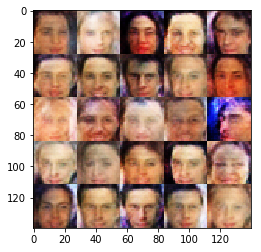

Epoch 1/1... Discriminator Loss: 1.6220... Generator Loss: 0.5747
Epoch 1/1... Discriminator Loss: 1.0466... Generator Loss: 0.8628
Epoch 1/1... Discriminator Loss: 0.7264... Generator Loss: 0.8131
Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 0.4593
Epoch 1/1... Discriminator Loss: 1.6241... Generator Loss: 0.6314
Epoch 1/1... Discriminator Loss: 1.2565... Generator Loss: 0.8090
Epoch 1/1... Discriminator Loss: 0.9527... Generator Loss: 0.8184


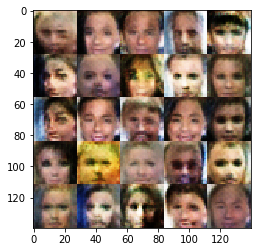

Epoch 1/1... Discriminator Loss: 1.5273... Generator Loss: 0.5846
Epoch 1/1... Discriminator Loss: 1.3357... Generator Loss: 0.7027
Epoch 1/1... Discriminator Loss: 1.2364... Generator Loss: 1.1650
Epoch 1/1... Discriminator Loss: 0.8308... Generator Loss: 0.6082
Epoch 1/1... Discriminator Loss: 0.8990... Generator Loss: 0.7054
Epoch 1/1... Discriminator Loss: 1.2936... Generator Loss: 0.8670
Epoch 1/1... Discriminator Loss: 1.7786... Generator Loss: 1.5946
Epoch 1/1... Discriminator Loss: 0.6575... Generator Loss: 1.0680


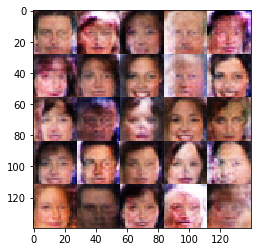

Epoch 1/1... Discriminator Loss: 0.8174... Generator Loss: 0.6193
Epoch 1/1... Discriminator Loss: 0.8841... Generator Loss: 0.7552
Epoch 1/1... Discriminator Loss: 1.3127... Generator Loss: 0.5911
Epoch 1/1... Discriminator Loss: 1.5099... Generator Loss: 1.5825
Epoch 1/1... Discriminator Loss: 0.9963... Generator Loss: 0.8283
Epoch 1/1... Discriminator Loss: 0.9783... Generator Loss: 0.6284
Epoch 1/1... Discriminator Loss: 1.1651... Generator Loss: 0.6008


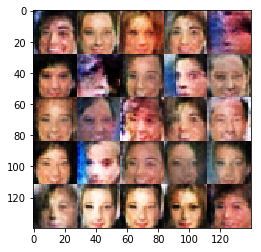

Epoch 1/1... Discriminator Loss: 1.8254... Generator Loss: 0.3602
Epoch 1/1... Discriminator Loss: 1.2435... Generator Loss: 0.7581
Epoch 1/1... Discriminator Loss: 0.8631... Generator Loss: 0.6900
Epoch 1/1... Discriminator Loss: 1.1810... Generator Loss: 0.7631
Epoch 1/1... Discriminator Loss: 1.2850... Generator Loss: 0.7673
Epoch 1/1... Discriminator Loss: 0.8792... Generator Loss: 0.7212
Epoch 1/1... Discriminator Loss: 1.3016... Generator Loss: 0.7037
Epoch 1/1... Discriminator Loss: 1.2870... Generator Loss: 0.3807


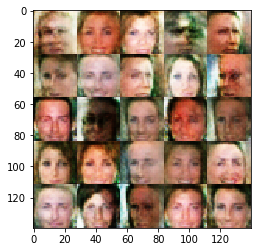

Epoch 1/1... Discriminator Loss: 0.9688... Generator Loss: 1.0418
Epoch 1/1... Discriminator Loss: 1.1550... Generator Loss: 1.3104
Epoch 1/1... Discriminator Loss: 0.9560... Generator Loss: 0.8200
Epoch 1/1... Discriminator Loss: 1.2325... Generator Loss: 0.5921
Epoch 1/1... Discriminator Loss: 1.1641... Generator Loss: 0.5896
Epoch 1/1... Discriminator Loss: 0.8646... Generator Loss: 0.6021
Epoch 1/1... Discriminator Loss: 1.0103... Generator Loss: 0.7207


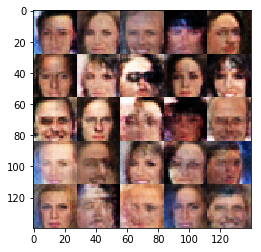

Epoch 1/1... Discriminator Loss: 1.2777... Generator Loss: 1.2728
Epoch 1/1... Discriminator Loss: 1.0014... Generator Loss: 0.6436
Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 0.3634
Epoch 1/1... Discriminator Loss: 1.2279... Generator Loss: 0.9244
Epoch 1/1... Discriminator Loss: 0.9793... Generator Loss: 1.3358
Epoch 1/1... Discriminator Loss: 1.3384... Generator Loss: 0.5801
Epoch 1/1... Discriminator Loss: 1.5717... Generator Loss: 0.4843
Epoch 1/1... Discriminator Loss: 1.1578... Generator Loss: 0.4394


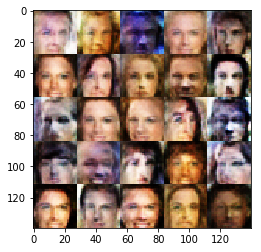

Epoch 1/1... Discriminator Loss: 1.0179... Generator Loss: 1.0791
Epoch 1/1... Discriminator Loss: 0.6437... Generator Loss: 0.6428
Epoch 1/1... Discriminator Loss: 1.0690... Generator Loss: 0.7292
Epoch 1/1... Discriminator Loss: 1.2796... Generator Loss: 2.0311
Epoch 1/1... Discriminator Loss: 0.8352... Generator Loss: 1.1143
Epoch 1/1... Discriminator Loss: 1.6765... Generator Loss: 0.5711
Epoch 1/1... Discriminator Loss: 1.0608... Generator Loss: 0.7613


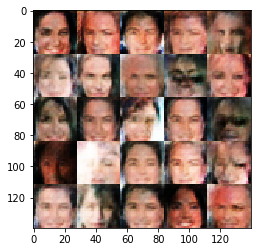

Epoch 1/1... Discriminator Loss: 1.3652... Generator Loss: 0.9127
Epoch 1/1... Discriminator Loss: 0.9424... Generator Loss: 0.3188
Epoch 1/1... Discriminator Loss: 1.3157... Generator Loss: 0.6357
Epoch 1/1... Discriminator Loss: 0.6417... Generator Loss: 0.5727
Epoch 1/1... Discriminator Loss: 1.9376... Generator Loss: 0.4742
Epoch 1/1... Discriminator Loss: 1.2433... Generator Loss: 0.3877
Epoch 1/1... Discriminator Loss: 1.2253... Generator Loss: 0.7837
Epoch 1/1... Discriminator Loss: 1.1356... Generator Loss: 1.0974


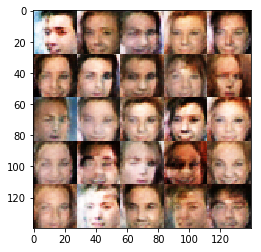

Epoch 1/1... Discriminator Loss: 0.8215... Generator Loss: 1.0581
Epoch 1/1... Discriminator Loss: 1.2543... Generator Loss: 0.7847
Epoch 1/1... Discriminator Loss: 1.2632... Generator Loss: 0.5532
Epoch 1/1... Discriminator Loss: 1.4492... Generator Loss: 0.2714
Epoch 1/1... Discriminator Loss: 1.2863... Generator Loss: 0.8405
Epoch 1/1... Discriminator Loss: 0.6570... Generator Loss: 0.7173
Epoch 1/1... Discriminator Loss: 1.0282... Generator Loss: 1.0291


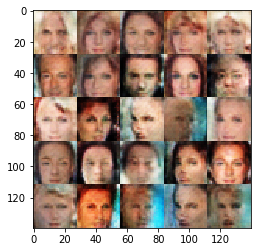

Epoch 1/1... Discriminator Loss: 1.2878... Generator Loss: 0.5696
Epoch 1/1... Discriminator Loss: 1.1273... Generator Loss: 0.8367
Epoch 1/1... Discriminator Loss: 1.2118... Generator Loss: 0.5008
Epoch 1/1... Discriminator Loss: 1.2729... Generator Loss: 1.3824
Epoch 1/1... Discriminator Loss: 1.1562... Generator Loss: 0.7697
Epoch 1/1... Discriminator Loss: 1.1455... Generator Loss: 0.7819
Epoch 1/1... Discriminator Loss: 1.4389... Generator Loss: 0.4909
Epoch 1/1... Discriminator Loss: 1.4402... Generator Loss: 0.4842


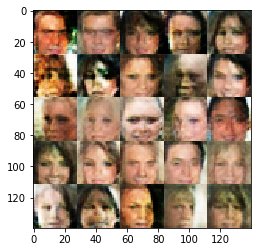

Epoch 1/1... Discriminator Loss: 1.1213... Generator Loss: 0.8359
Epoch 1/1... Discriminator Loss: 1.5560... Generator Loss: 0.3866
Epoch 1/1... Discriminator Loss: 1.0100... Generator Loss: 0.8634
Epoch 1/1... Discriminator Loss: 1.0772... Generator Loss: 0.6605
Epoch 1/1... Discriminator Loss: 1.2965... Generator Loss: 0.8209
Epoch 1/1... Discriminator Loss: 1.1496... Generator Loss: 0.5751
Epoch 1/1... Discriminator Loss: 1.0448... Generator Loss: 0.6876


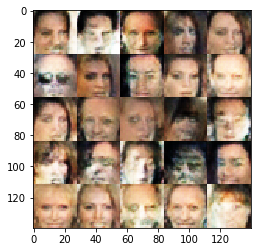

Epoch 1/1... Discriminator Loss: 1.2559... Generator Loss: 0.6237
Epoch 1/1... Discriminator Loss: 1.2221... Generator Loss: 1.4029
Epoch 1/1... Discriminator Loss: 1.1189... Generator Loss: 0.5997
Epoch 1/1... Discriminator Loss: 1.3533... Generator Loss: 0.9977
Epoch 1/1... Discriminator Loss: 1.3583... Generator Loss: 1.0111
Epoch 1/1... Discriminator Loss: 0.7341... Generator Loss: 0.6786
Epoch 1/1... Discriminator Loss: 0.8266... Generator Loss: 1.0530
Epoch 1/1... Discriminator Loss: 1.5586... Generator Loss: 0.3192


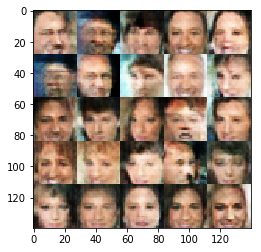

Epoch 1/1... Discriminator Loss: 1.2115... Generator Loss: 0.7158
Epoch 1/1... Discriminator Loss: 0.5957... Generator Loss: 0.7425
Epoch 1/1... Discriminator Loss: 1.0821... Generator Loss: 0.4598
Epoch 1/1... Discriminator Loss: 1.2279... Generator Loss: 0.9325
Epoch 1/1... Discriminator Loss: 0.9105... Generator Loss: 0.4876
Epoch 1/1... Discriminator Loss: 1.8905... Generator Loss: 0.1632
Epoch 1/1... Discriminator Loss: 1.2826... Generator Loss: 0.6866


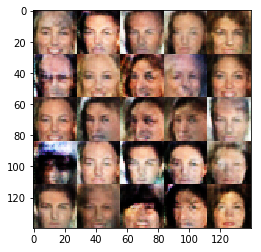

Epoch 1/1... Discriminator Loss: 0.9417... Generator Loss: 0.8363
Epoch 1/1... Discriminator Loss: 1.3525... Generator Loss: 0.6124
Epoch 1/1... Discriminator Loss: 0.7122... Generator Loss: 0.8797
Epoch 1/1... Discriminator Loss: 1.0002... Generator Loss: 0.8507
Epoch 1/1... Discriminator Loss: 0.8630... Generator Loss: 1.0099
Epoch 1/1... Discriminator Loss: 1.8374... Generator Loss: 0.5651
Epoch 1/1... Discriminator Loss: 1.0494... Generator Loss: 0.6787
Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 1.4472


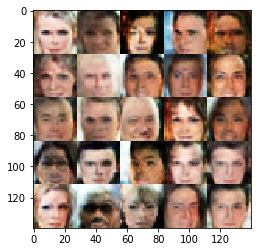

Epoch 1/1... Discriminator Loss: 1.5479... Generator Loss: 0.4454
Epoch 1/1... Discriminator Loss: 1.1465... Generator Loss: 0.6371
Epoch 1/1... Discriminator Loss: 0.9727... Generator Loss: 0.6236
Epoch 1/1... Discriminator Loss: 1.1099... Generator Loss: 0.2894
Epoch 1/1... Discriminator Loss: 1.2907... Generator Loss: 0.5786
Epoch 1/1... Discriminator Loss: 1.1969... Generator Loss: 0.5197
Epoch 1/1... Discriminator Loss: 0.9946... Generator Loss: 0.7619


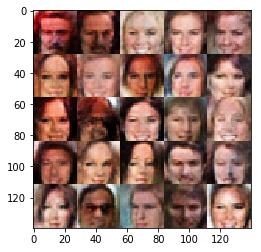

Epoch 1/1... Discriminator Loss: 1.3147... Generator Loss: 0.5570
Epoch 1/1... Discriminator Loss: 0.9602... Generator Loss: 0.5518
Epoch 1/1... Discriminator Loss: 1.4663... Generator Loss: 0.6327
Epoch 1/1... Discriminator Loss: 1.1966... Generator Loss: 0.7476
Epoch 1/1... Discriminator Loss: 1.2356... Generator Loss: 1.3592
Epoch 1/1... Discriminator Loss: 1.4429... Generator Loss: 0.4114
Epoch 1/1... Discriminator Loss: 0.8263... Generator Loss: 1.0813
Epoch 1/1... Discriminator Loss: 1.1014... Generator Loss: 0.8987


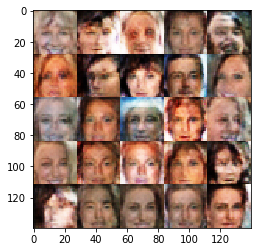

Epoch 1/1... Discriminator Loss: 1.5039... Generator Loss: 0.5160
Epoch 1/1... Discriminator Loss: 0.9836... Generator Loss: 1.1530
Epoch 1/1... Discriminator Loss: 1.6145... Generator Loss: 0.4231
Epoch 1/1... Discriminator Loss: 0.9383... Generator Loss: 0.7441
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.6289
Epoch 1/1... Discriminator Loss: 1.3502... Generator Loss: 0.5768
Epoch 1/1... Discriminator Loss: 0.9408... Generator Loss: 0.3730


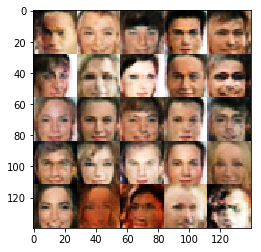

Epoch 1/1... Discriminator Loss: 1.3242... Generator Loss: 0.7779
Epoch 1/1... Discriminator Loss: 1.1345... Generator Loss: 0.3946
Epoch 1/1... Discriminator Loss: 1.3083... Generator Loss: 0.4057
Epoch 1/1... Discriminator Loss: 1.2421... Generator Loss: 0.5864
Epoch 1/1... Discriminator Loss: 1.3553... Generator Loss: 0.4550
Epoch 1/1... Discriminator Loss: 1.1996... Generator Loss: 0.6982
Epoch 1/1... Discriminator Loss: 1.0915... Generator Loss: 0.7581
Epoch 1/1... Discriminator Loss: 1.1423... Generator Loss: 0.9305


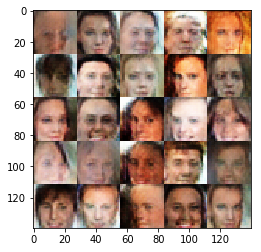

Epoch 1/1... Discriminator Loss: 1.2410... Generator Loss: 0.6013
Epoch 1/1... Discriminator Loss: 0.9878... Generator Loss: 0.7880
Epoch 1/1... Discriminator Loss: 1.1903... Generator Loss: 0.5554
Epoch 1/1... Discriminator Loss: 1.1633... Generator Loss: 0.7905
Epoch 1/1... Discriminator Loss: 1.1766... Generator Loss: 1.2178
Epoch 1/1... Discriminator Loss: 1.2574... Generator Loss: 0.7744
Epoch 1/1... Discriminator Loss: 1.1294... Generator Loss: 0.6639


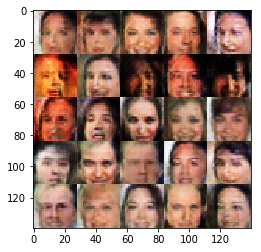

Epoch 1/1... Discriminator Loss: 1.5863... Generator Loss: 0.6153
Epoch 1/1... Discriminator Loss: 1.1379... Generator Loss: 0.8188
Epoch 1/1... Discriminator Loss: 1.2284... Generator Loss: 0.7275
Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.5726
Epoch 1/1... Discriminator Loss: 0.9804... Generator Loss: 0.7922
Epoch 1/1... Discriminator Loss: 2.0309... Generator Loss: 0.1411
Epoch 1/1... Discriminator Loss: 1.1508... Generator Loss: 0.7559
Epoch 1/1... Discriminator Loss: 0.9051... Generator Loss: 1.0783


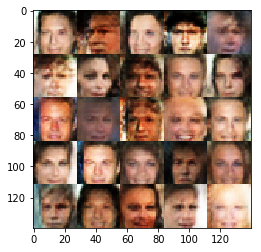

Epoch 1/1... Discriminator Loss: 1.2606... Generator Loss: 0.8260
Epoch 1/1... Discriminator Loss: 0.5770... Generator Loss: 0.7619
Epoch 1/1... Discriminator Loss: 1.2266... Generator Loss: 1.0649
Epoch 1/1... Discriminator Loss: 1.3020... Generator Loss: 0.7390
Epoch 1/1... Discriminator Loss: 1.5720... Generator Loss: 0.5022
Epoch 1/1... Discriminator Loss: 1.1889... Generator Loss: 0.9624
Epoch 1/1... Discriminator Loss: 1.0671... Generator Loss: 0.6662


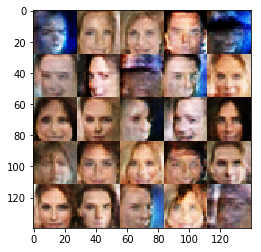

Epoch 1/1... Discriminator Loss: 1.5038... Generator Loss: 0.5226
Epoch 1/1... Discriminator Loss: 0.9270... Generator Loss: 0.7473
Epoch 1/1... Discriminator Loss: 1.3229... Generator Loss: 1.0359
Epoch 1/1... Discriminator Loss: 1.1641... Generator Loss: 0.4874
Epoch 1/1... Discriminator Loss: 1.1818... Generator Loss: 1.5783
Epoch 1/1... Discriminator Loss: 0.9843... Generator Loss: 1.3548
Epoch 1/1... Discriminator Loss: 1.1684... Generator Loss: 1.1801
Epoch 1/1... Discriminator Loss: 1.1021... Generator Loss: 1.1896


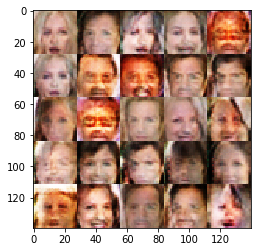

Epoch 1/1... Discriminator Loss: 1.1253... Generator Loss: 1.3868
Epoch 1/1... Discriminator Loss: 1.7196... Generator Loss: 0.4227
Epoch 1/1... Discriminator Loss: 0.9720... Generator Loss: 1.0718
Epoch 1/1... Discriminator Loss: 1.0034... Generator Loss: 1.0904
Epoch 1/1... Discriminator Loss: 1.1171... Generator Loss: 0.5330
Epoch 1/1... Discriminator Loss: 1.2425... Generator Loss: 0.5486
Epoch 1/1... Discriminator Loss: 0.6875... Generator Loss: 0.6327


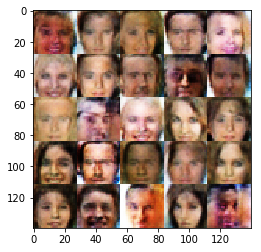

Epoch 1/1... Discriminator Loss: 1.1388... Generator Loss: 0.6276
Epoch 1/1... Discriminator Loss: 1.0659... Generator Loss: 0.7227
Epoch 1/1... Discriminator Loss: 1.5553... Generator Loss: 0.5438
Epoch 1/1... Discriminator Loss: 1.4131... Generator Loss: 0.4866
Epoch 1/1... Discriminator Loss: 1.0863... Generator Loss: 0.7151
Epoch 1/1... Discriminator Loss: 0.7112... Generator Loss: 0.8757
Epoch 1/1... Discriminator Loss: 1.1404... Generator Loss: 1.4723
Epoch 1/1... Discriminator Loss: 1.0772... Generator Loss: 0.6755


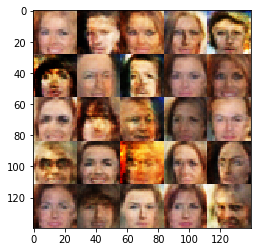

Epoch 1/1... Discriminator Loss: 1.1907... Generator Loss: 0.7556
Epoch 1/1... Discriminator Loss: 1.1088... Generator Loss: 0.7601
Epoch 1/1... Discriminator Loss: 1.1343... Generator Loss: 0.9356
Epoch 1/1... Discriminator Loss: 0.8682... Generator Loss: 0.5910
Epoch 1/1... Discriminator Loss: 0.8529... Generator Loss: 0.6582
Epoch 1/1... Discriminator Loss: 1.4986... Generator Loss: 0.4514
Epoch 1/1... Discriminator Loss: 1.6888... Generator Loss: 1.4932


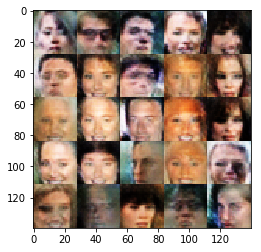

Epoch 1/1... Discriminator Loss: 1.1501... Generator Loss: 0.7855
Epoch 1/1... Discriminator Loss: 1.2582... Generator Loss: 0.7571
Epoch 1/1... Discriminator Loss: 1.2543... Generator Loss: 1.0702
Epoch 1/1... Discriminator Loss: 1.2680... Generator Loss: 0.7117
Epoch 1/1... Discriminator Loss: 1.4881... Generator Loss: 0.5640
Epoch 1/1... Discriminator Loss: 1.5529... Generator Loss: 0.2210
Epoch 1/1... Discriminator Loss: 1.1510... Generator Loss: 0.7470
Epoch 1/1... Discriminator Loss: 1.1405... Generator Loss: 0.5736


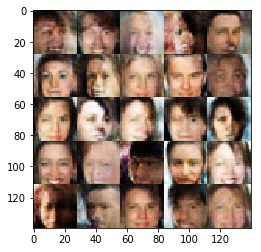

Epoch 1/1... Discriminator Loss: 1.6455... Generator Loss: 0.6130
Epoch 1/1... Discriminator Loss: 1.0466... Generator Loss: 1.3550
Epoch 1/1... Discriminator Loss: 0.8293... Generator Loss: 0.7656
Epoch 1/1... Discriminator Loss: 1.1370... Generator Loss: 1.2460
Epoch 1/1... Discriminator Loss: 0.9274... Generator Loss: 0.6562
Epoch 1/1... Discriminator Loss: 1.0340... Generator Loss: 0.6568
Epoch 1/1... Discriminator Loss: 1.2348... Generator Loss: 0.8686


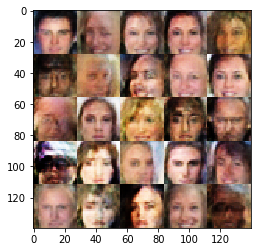

Epoch 1/1... Discriminator Loss: 0.9279... Generator Loss: 0.8642
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.5000
Epoch 1/1... Discriminator Loss: 1.4631... Generator Loss: 0.5042
Epoch 1/1... Discriminator Loss: 1.2231... Generator Loss: 0.6428
Epoch 1/1... Discriminator Loss: 1.3160... Generator Loss: 0.5518
Epoch 1/1... Discriminator Loss: 0.7985... Generator Loss: 0.4040
Epoch 1/1... Discriminator Loss: 1.0248... Generator Loss: 0.4812
Epoch 1/1... Discriminator Loss: 0.8790... Generator Loss: 0.8018


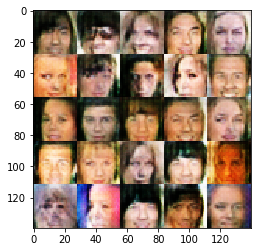

Epoch 1/1... Discriminator Loss: 1.1959... Generator Loss: 0.8330
Epoch 1/1... Discriminator Loss: 1.1681... Generator Loss: 0.9737
Epoch 1/1... Discriminator Loss: 1.5014... Generator Loss: 0.5767
Epoch 1/1... Discriminator Loss: 1.0706... Generator Loss: 1.4353
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.6557
Epoch 1/1... Discriminator Loss: 1.0691... Generator Loss: 0.7027
Epoch 1/1... Discriminator Loss: 1.3427... Generator Loss: 0.9499


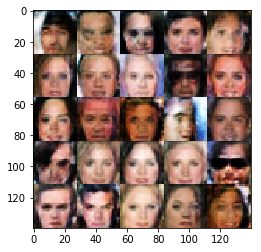

Epoch 1/1... Discriminator Loss: 0.7819... Generator Loss: 0.2660
Epoch 1/1... Discriminator Loss: 0.8599... Generator Loss: 0.6962
Epoch 1/1... Discriminator Loss: 1.0639... Generator Loss: 0.5386
Epoch 1/1... Discriminator Loss: 0.9955... Generator Loss: 0.9331
Epoch 1/1... Discriminator Loss: 1.3360... Generator Loss: 0.7362
Epoch 1/1... Discriminator Loss: 1.1272... Generator Loss: 0.6231
Epoch 1/1... Discriminator Loss: 1.4445... Generator Loss: 0.2909
Epoch 1/1... Discriminator Loss: 1.1189... Generator Loss: 0.7507


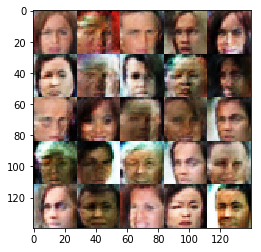

Epoch 1/1... Discriminator Loss: 1.1542... Generator Loss: 0.5786
Epoch 1/1... Discriminator Loss: 0.8491... Generator Loss: 0.5558
Epoch 1/1... Discriminator Loss: 0.6193... Generator Loss: 0.4995


In [22]:
batch_size = 16
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.